# Simulation code of SSA and new algorithm for FRP and DT systems

Hang Yin

Packages used

In [1]:
using Random, Distributions, ProgressMeter, StatsBase, PlotlyJS, BenchmarkTools, HypothesisTests

WebIO._IJuliaInit()

Plot function

In [2]:
function Data_Plot(Sys)
    fig = make_subplots(
        rows=3, cols=3,
        specs=[
            Spec(kind="xy", colspan=2)   missing                     Spec(kind="xy")
            # missing                                 missing                     missing
            Spec(kind="xy", colspan=2)   missing                     Spec(kind="xy")
            # missing                                 missing                     missing
            Spec(kind="xy")              Spec(kind="xy")             Spec(kind="xy")
            # missing                                 missing                     missing
        ]
    )
    color_map = Dict(
        80 => "purple",
        70 => "blue",
        60 => "cyan ",
        50 => "green",
        40 => "yellow",
        30 => "orange",
        20 => "red",
        10 => "brown" # gray pink
    )

    max_x = 3*maximum(Sys[:Series][:X_n])
    for i in 80:-10:10
        trace = scatter(x=1:max_x, y=Sys[:Critical]["$(i)%"][:Data], name="$(i)%", mode="lines", line=attr(color=color_map[i]))
        add_trace!(fig, trace, row=1, col=1)
    end
    
    k1 = 1
    k2 = 1
    Gap = 2
    Critical = ["10%","20%","30%","40%","50%","60%","70%","80%"]
    function cut(values, breaks; extend::Bool = false)
        intervals = Vector{Int}(undef, length(values))
        breaks = sort(breaks)  # Ensure breaks are sorted
        if extend
            breaks = [minimum([minimum(values); breaks]) - eps(), breaks..., maximum([maximum(values); breaks]) + eps()]
        end
        length_value = length(values)
        for i in 1:length_value
            intervals[i] = findfirst(x -> values[i] <= x, breaks) - 1
        end
        
        return intervals
    end

    for i in 80:-10:10
        Weight = Sys[:Critical]["$(i)%"][:Data]
        Max_MW = findlast(x -> x != 0, Weight)
        Breaks = 0:Gap:Max_MW
        Intervals = cut(1:Max_MW, Breaks, extend = true)
        Temp = Weight[1:Max_MW] .* (1:Max_MW)
        Weight_intervals = [sum(Temp[findall(x -> x == interval, Intervals)]) for interval in unique(Intervals)]
        Numbers = [sum(Weight[1:Max_MW][findall(x -> x == interval, Intervals)]) for interval in unique(Intervals)]

        GPC_Result = zeros(length(Numbers), 2)
        non_zero_indices = findall(x -> x != 0, Weight_intervals)
        if !isempty(non_zero_indices)
            GPC_Result[non_zero_indices, 1] .= log10.(Weight_intervals[non_zero_indices] ./ Numbers[non_zero_indices]) .* k1 .+ k2
            GPC_Result[non_zero_indices, 2] .= (-0.4228 .* GPC_Result[non_zero_indices, 1] .+ 10.38) .* Weight_intervals[non_zero_indices]
            GPC_Result = GPC_Result[findall(x -> x != 0, GPC_Result[:, 2]), :]
            trace = scatter(x = GPC_Result[:, 1], y = GPC_Result[:, 2], name="$(i)%", mode = "lines", line=attr(color=color_map[i]), showlegend=false)
            add_trace!(fig, trace, row=2, col=1)
        end
    end

    add_trace!(
        fig,
        scatter(x=Sys[:Series][:Time], y=Sys[:Series][:Radical], mode="markers", name="Radical", line=attr(color="gray")),
        row=1, col=3
    )

    add_trace!(
        fig,
        scatter(x=Sys[:Series][:Time], y=sqrt.(5.981*10^(-14).*exp.(-3.780*10^(-5)*Sys[:Series][:Time]))*Sys[:Initial][:M]/5, mode="lines", name="Theoretical", line=attr(color="red")),
        row=1, col=3
    )

    add_trace!(
        fig,
        scatter(
            x=Sys[:Series][:Time], 
            y=Sys[:Series][:P], 
            name="Time v.s. Conv.",
            mode="lines", line=attr(color="black"), 
            showlegend=false
        ),
        row=2, col=3
    )

    add_trace!(
        fig,
        scatter(
            x=Sys[:Series][:P], 
            y=Sys[:Series][:X_n], 
            mode="lines", line=attr(color="black"), 
            name="X_n",
            showlegend=false
            ),
        row=3, col=1
    )

    add_trace!(
        fig,
        scatter(
            x=Sys[:Series][:P], 
            y=Sys[:Series][:X_w], 
            name="X_n",
            mode="lines", line=attr(color="black"), 
            showlegend=false
        ),
        row=3, col=2
    )

    add_trace!(
        fig,
        scatter(x=Sys[:Series][:P], 
        y=Sys[:Series][:PDI], 
        name="X_n",
        mode="lines", line=attr(color="black"), 
        showlegend=false ),
        row=3, col=3
    )

    relayout!(fig, 
        xaxis = attr(title="Chain Length", autorange="reversed"),
        yaxis = attr(title="???"), 
        xaxis2 = attr(title="Time"),
        yaxis2 = attr(title="Amount"), 
        xaxis3 = attr(title="Chain Length"),
        yaxis3 = attr(title="???"), 
        xaxis4= attr(title="Time"),
        yaxis4 = attr(title="Conv."), 
        xaxis5= attr(title="Conv. "),
        yaxis5 = attr(title="X_n"),
        xaxis6= attr(title="Conv. "),
        yaxis6 = attr(title="X_w"),
        xaxis7= attr(title="Conv. "),
        yaxis7 = attr(title="PDI"),
        legend = attr(x = 1, y = 1, xanchor = "left", yanchor = "top"),
        template=templates.plotly_white
    )
    fig
end

Data_Plot (generic function with 1 method)

##  Free Radical Polymerization (FRP)

In [3]:
function SSA_FRP(M::Int=10^9)
    # M = 10^9
    I = div(M, 100)
    # CTA = div(M, 100)

    P_lists = 0.0001:0.0001:0.1
    P_critical = 0:0.1:0.8
    Max_count = 6000
    
    k_I       = 3.780 * 10^(-5)
    k_p       = 1.039 * 10^( 3) * 5 / M 
    k_T       = 3.160 * 10^( 7) * 5 / M * 2
    k_CTAgent = 1.000 * 10^  5  * 0
    k_CTADE   = 1.000 * 10^  5  * 0

    # Current Stage
    Monomer = M
    Initiator = I
    Radical = Int[]
    # CTAgent = Int[]
    # Intermediate = Int[]
    Termination = zeros(Int, Max_count+1)
    P_Current = 0.0
    Time_Current = 0.0

    M_list           = zeros(Int, 8001)
    Time_list        = zeros(8001)
    Radical_list     = zeros(Int, 8001)
    Termination_list = zeros(Int, 8001)
    X_n_list         = ones(8001)
    X_w_list         = ones(8001)

    System = Dict{Symbol, Dict}(
        :k => Dict{Symbol,Float64}(
            :I           => k_I,
            :p           => k_p,
            :Termination => k_T,
            :CTAgent     => k_CTAgent,
            :CTADE       => k_CTADE
        ),
        :Initial => Dict(
            :M => M,
            :I => I
        ),
        :Critical => Dict{String, Dict}("$(i*10)%" => Dict{String,Vector{Int}}() for i in 1:8),
    )
    Temp_react = [k_I * Initiator, 0, 0]
    length_Radical = 0

    for i in 1:8
        println("\n$(P_critical[i]*100)% ~ $(P_critical[i+1]*100)%")

        @showprogress for j in 1:1000
            P_threshold = P_critical[i] + P_lists[j]

            while P_Current < P_threshold
                Temp_time = rand(Exponential(1 / sum(Temp_react)))
                Time_Current += Temp_time

                Temp_react_class = cumsum(Temp_react) / sum(Temp_react)
                Index_01 = rand()

                if Index_01 < Temp_react_class[1]
                    Initiator -= 1
                    push!(Radical, 0, 0)
                    length_Radical += 2
                    Temp_react = [k_I*Initiator, k_p*length_Radical*Monomer, k_T*(length_Radical)^2/2]
                elseif Index_01 < Temp_react_class[2]
                    Monomer -= 1
                    Index = rand(1:length_Radical)
                    Radical[Index] += 1
                    P_Current = 1 - Monomer / M
                    Temp_react[2] = k_p*length_Radical*Monomer
                elseif Index_01 < Temp_react_class[3] && length_Radical >= 2
                    selected = sort(sample(1:length_Radical, 2, replace=false))
                    Length = sum(Radical[selected])
                    Termination[Length + 1] += 1
                    deleteat!(Radical, selected)
                    length_Radical -= 2
                    Temp_react[[2,3]] = [k_p*length_Radical*Monomer, k_T*(length_Radical)^2/2]
                end
            end

            Index_State = 1000 * (i - 1) + j + 1
            M_list[Index_State] = Monomer
            Time_list[Index_State] = Time_Current
            Radical_list[Index_State] = length(Radical)
            Termination_list[Index_State] = sum(Termination)
            Data = copy(Termination[2:end])
            Counts = countmap(Radical)
            Counts = filter(x -> x[1] != 0, Counts)
            for (idx, count) in Counts
                if idx <= length(Data)
                    Data[idx] += count
                else
                    push!(Data, count)
                end
            end
            X_n_list[Index_State] = sum(Data .* (1:Max_count)) / sum(Data)
            X_w_list[Index_State] = sum(Data .* (1:Max_count).^2) / sum(Data .* (1:Max_count))
        end

        Data = copy(Termination[2:end])
        Counts = countmap(Radical)
        Counts = filter(x -> x[1] != 0, Counts)
        for (idx, count) in Counts
            if idx <= length(Data)
                Data[idx] += count
            else
                push!(Data, count)
            end
        end

        System[:Critical]["$(i*10)%"] = Dict(
            # :CTAgent => CTAgent,
            # :Intermediate => Intermediate,
            :Data => Data
        )
    end

    PDI_list = X_w_list ./ X_n_list
    System[:Series] = Dict{Symbol, AbstractVector}(
        :P           => 0:0.0001:0.8,
        :M           => M_list,
        :Time        => Time_list,
        :Radical     => Radical_list,
        :Termination => Termination_list,
        :X_n         => X_n_list,
        :X_w         => X_w_list,
        :PDI         => PDI_list
    )

    Data = Termination[2:end]
    Counts = countmap(Radical)
    Counts = filter(x -> x[1] != 0, Counts)
    for (idx, count) in Counts
        if idx <= length(Data)
            Data[idx] += count
        else
            push!(Data, count)
        end
    end
    System[:Bias] = Dict{Symbol,Int64}(
        :M => sum(Data .* (1:Max_count)) + Monomer             - M,
        :I => Initiator + length(Radical)/2 + sum(Termination) - I
    )

    return System
end

SSA_FRP (generic function with 2 methods)

In [4]:
function New_Leaping_FRP(M::Int=10^9)
    # M = 10^9
    I = M/100
    # CTA = M/100

    P_lists = 0.0001:0.0001:0.1
    P_critical = 0:0.1:0.8
    Max_count = 6000
    
    k_I       = 3.780 * 10^(-5)
    k_p       = 1.039 * 10^( 3) * 5 / M 
    k_T       = 3.160 * 10^( 7) * 5 / M * 2
    k_CTAgent = 1.000 * 10^  5  * 0
    k_CTADE   = 1.000 * 10^  5  * 0

    # Current Stage
    Monomer = M
    Initiator = I
    Radical = Int[]
    # CTAgent = Int[]
    # Intermediate = Int[]
    Termination = zeros(Int, Max_count+1)
    P_Current = 0.0
    Time_Current = 0.0

    M_list           = zeros(Int, 8001)
    Time_list        = zeros(8001)
    Radical_list     = zeros(Int, 8001)
    Termination_list = zeros(Int, 8001)
    X_n_list         = ones(8001)
    X_w_list         = ones(8001)

    System = Dict{Symbol, Dict}(
        :k => Dict{Symbol,Float64}(
            :I           => k_I,
            :p           => k_p,
            :Termination => k_T,
            :CTAgent     => k_CTAgent,
            :CTADE       => k_CTADE
        ),
        :Initial => Dict{Symbol,Int}(
            :M => M,
            :I => I
        ),
        :Critical => Dict{String, Dict}("$(i*10)%" => Dict{String,Vector{Int}}() for i in 1:8),
    )

    Temp_react = [k_I * Initiator, 0]
    length_Radical = 0

    for i in 1:8
        println("\n$(P_critical[i]*100)% ~ $(P_critical[i+1]*100)%")

        @showprogress for j in 1:1000
            P_threshold = P_critical[i] + P_lists[j]

            while P_Current < P_threshold
                Temp_time = rand(Exponential(1 / sum(Temp_react)))
                Time_Current += Temp_time

                Propagation = rand(Poisson(k_p * length_Radical * Monomer * Temp_time))
                Monomer -= Propagation
                
                Index = sample(1:length_Radical, Propagation, replace=true)
                    Counts = countmap(Index)
                    # Update Radical according to Counts
                    for (idx, count) in Counts
                        Radical[idx] += count
                    end
                P_Current = 1 - Monomer / M

                Temp_react_class = cumsum(Temp_react) / sum(Temp_react)
                Index_01 = rand()

                if Index_01 < Temp_react_class[1]
                    Initiator -= 1
                    push!(Radical, 0, 0)
                    length_Radical += 2
                    Temp_react = [k_I * Initiator,k_T * (length_Radical)^2 / 2]

                elseif Index_01 < Temp_react_class[2] && length_Radical >= 2
                    selected = sort(sample(1:length_Radical, 2, replace=false))
                    Length = sum(Radical[selected])
                    Termination[Length + 1] += 1
                    deleteat!(Radical, selected)
                    length_Radical -= 2
                    Temp_react[2] = k_T * (length_Radical)^2 / 2
                end
            end

            Index_State = 1000 * (i - 1) + j + 1
            M_list[Index_State] = Monomer
            Time_list[Index_State] = Time_Current
            Radical_list[Index_State] = length(Radical)
            Termination_list[Index_State] = sum(Termination)
            Data = copy(Termination[2:end])
            Counts = countmap(Radical)
            Counts = filter(x -> x[1] != 0, Counts)
            for (idx, count) in Counts
                if idx <= length(Data)
                    Data[idx] += count
                else
                    push!(Data, count)
                end
            end
            X_n_list[Index_State] = sum(Data .* (1:Max_count)) / sum(Data)
            X_w_list[Index_State] = sum(Data .* (1:Max_count).^2) / sum(Data .* (1:Max_count))
        end

        Data = Termination[2:end]
        Counts = countmap(Radical)
        Counts = filter(x -> x[1] != 0, Counts)
        for (idx, count) in Counts
            if idx <= length(Data)
                Data[idx] += count
            else
                push!(Data, count)
            end
        end
        #all = sum(Data)
        #Data = Data / all

        System[:Critical]["$(i*10)%"] = Dict(
            # :CTAgent => CTAgent,
            # :Intermediate => Intermediate,
            :Data => Data
        )
    end

    PDI_list = X_w_list ./ X_n_list
    System[:Series] = Dict{Symbol, AbstractVector}(
        :P           => 0:0.0001:0.8,
        :M           => M_list,
        :Time        => Time_list,
        :Radical     => Radical_list,
        :Termination => Termination_list,
        :X_n         => X_n_list,
        :X_w         => X_w_list,
        :PDI         => PDI_list
    )

    # Test Bias
    Data = Termination[2:end]
    Counts = countmap(Radical)
    Counts = filter(x -> x[1] != 0, Counts)
    for (idx, count) in Counts
        if idx <= length(Data)
            Data[idx] += count
        else
            push!(Data, count)
        end
    end
    System[:Bias] = Dict{Symbol,Int64}(
        :M => sum(Data .* (1:Max_count)) + Monomer             - M,
        :I => Initiator + length(Radical)/2 + sum(Termination) - I
    )
    
    # System[:MSE] = cal_MSE(8,Data)

    return System
end

New_Leaping_FRP (generic function with 2 methods)

In [5]:
Random.seed!(1)
@time Data_FRP_SSA = SSA_FRP(10^9)

Progress:   0%|█                                        |  ETA: 0:00:21


0.0% ~ 10.0%


Progress: 100%|█████████████████████████████████████████| Time: 0:00:11



10.0% ~ 20.0%


Progress: 100%|█████████████████████████████████████████| Time: 0:00:11



20.0% ~ 30.0%

Progress:   1%|█                                        |  ETA: 0:00:11

Progress: 100%|█████████████████████████████████████████| Time: 0:00:11



30.0% ~ 40.0%


Progress: 100%|█████████████████████████████████████████| Time: 0:00:11



40.0% ~ 50.0%

Progress:   2%|█                                        |  ETA: 0:00:05


50.0% ~ 60.0%


Progress: 100%|█████████████████████████████████████████| Time: 0:00:11
Progress:  99%|█████████████████████████████████████████|  ETA: 0:00:00


60.0% ~ 70.0%


Progress: 100%|█████████████████████████████████████████| Time: 0:00:11



70.0% ~ 80.0%

Progress: 100%|█████████████████████████████████████████| Time: 0:00:11
Progress:   1%|█                                        |  ETA: 0:00:12

 92.266896 seconds (1.62 G allocations: 122.804 GiB, 6.22% gc time, 0.71% compilation time)


Progress: 100%|█████████████████████████████████████████| Time: 0:00:11


Dict{Symbol, Dict} with 5 entries:
  :Critical => Dict{String, Dict}("30%"=>Dict(:Data=>[30, 43, 55, 61, 63, 73, 7…
  :Series   => Dict{Symbol, AbstractVector}(:P=>0.0:0.0001:0.8, :X_w=>[1.0, 836…
  :k        => Dict(:I=>3.78e-5, :p=>5.195e-6, :CTAgent=>0.0, :Termination=>0.3…
  :Bias     => Dict(:I=>0, :M=>0)
  :Initial  => Dict(:I=>10000000, :M=>1000000000)

In [6]:
Random.seed!(1)
@time Data_FRP_New = New_Leaping_FRP(10^9)

Progress:   1%|█                                        |  ETA: 0:00:20


0.0% ~ 10.0%



10.0% ~ 20.0%


Progress: 100%|█████████████████████████████████████████| Time: 0:00:02
Progress: 100%|█████████████████████████████████████████| Time: 0:00:02
Progress:   4%|██                                       |  ETA: 0:00:02


20.0% ~ 30.0%


Progress: 100%|█████████████████████████████████████████| Time: 0:00:02



30.0% ~ 40.0%


Progress: 100%|█████████████████████████████████████████| Time: 0:00:02



40.0% ~ 50.0%

Progress:   6%|███                                      |  ETA: 0:00:02

Progress: 100%|█████████████████████████████████████████| Time: 0:00:02
Progress:   4%|██                                       |  ETA: 0:00:03


50.0% ~ 60.0%


Progress: 100%|█████████████████████████████████████████| Time: 0:00:02



60.0% ~ 70.0%

Progress: 100%|█████████████████████████████████████████| Time: 0:00:03
Progress:   3%|██                                       |  ETA: 0:00:03


70.0% ~ 80.0%


 21.927183 seconds (67.76 M allocations: 32.609 GiB, 7.17% gc time)


Progress: 100%|█████████████████████████████████████████| Time: 0:00:03


Dict{Symbol, Dict} with 5 entries:
  :Critical => Dict{String, Dict}("30%"=>Dict(:Data=>[42, 53, 48, 53, 59, 64, 7…
  :Series   => Dict{Symbol, AbstractVector}(:P=>0.0:0.0001:0.8, :X_w=>[1.0, 843…
  :k        => Dict(:I=>3.78e-5, :p=>5.195e-6, :CTAgent=>0.0, :Termination=>0.3…
  :Bias     => Dict(:I=>0, :M=>0)
  :Initial  => Dict(:I=>10000000, :M=>1000000000)

## Degenerative Transfer (DT)

In [7]:
function random_vector_efficient(x::Int, y::Int)
    indices = randperm(x + y)
    vec = zeros(Int, x + y)
    vec[indices[1:y]] .= 1
    return vec
end

function compute_difference(x::Int, y::Int)::Vector{Float64}
    v1 = [1:2:2*y; fill(2*y,x)]
    v2 = [fill(0,x); 1:2:2*y]
    return v1 .- v2
end

function extract_and_zero!(matrix)
    n, m = size(matrix)
    first_nonzeros = Vector{eltype(matrix)}(undef, n)
    @inbounds for i in 1:n
        row = @view matrix[i, :]
        k = findfirst(!iszero, row)
        first_nonzeros[i] = row[k]
        row[k] = 0
    end
    return first_nonzeros
end

function generate_matrix(n::Int, e::Int, vec::Vector{Int})
    mat = Matrix{Int}(undef, n, e)
    @inbounds @simd for i in 1:n
        mat[i, 1] = 1
    end
    @inbounds for row in 2:e
        prev_row = row - 1
        j = vec[row-1]
        @simd for i in 1:n
            mat[i, row] = mat[i, prev_row] + 1
        end
        mat[j, row] = 1
    end
    return mat
end

generate_matrix (generic function with 1 method)

In [8]:
function SSA_DT(M::Int=10^9)
    # M = 10^9
    I = div(M, 100)
    CTA = div(M, 100)

    P_lists = 0.0001:0.0001:0.1
    P_critical = 0:0.1:0.8
    Max_count = 2000

    k_I       = 3.780 * 10^(-5)
    k_p       = 1.039 * 10^( 3) * 5 / M 
    k_T       = 3.160 * 10^( 7) * 5 / M * 2
    k_CTAgent = 1.000 * 10^  5  * 5 / M
    k_CTADE   = 1.000 * 10^  5  * 0

    # Current Stage
    Monomer = M
    Initiator = I
    Radical = Int[]
    CTAgent = zeros(Int, Max_count+1)
    CTAgent[1] = CTA
    # Intermediate = Int[]
    Termination = zeros(Int, Max_count+1)
    P_Current = 0.0
    Time_Current = 0.0

    M_list           = zeros(Int, 8001)
    Time_list        = zeros(8001)
    Radical_list     = zeros(Int, 8001)
    Termination_list = zeros(Int, 8001)
    X_n_list         = ones(8001)
    X_w_list         = ones(8001)

    System = Dict{Symbol, Dict}(
        :k => Dict{Symbol,Float64}(
            :I           => k_I,
            :p           => k_p,
            :Termination => k_T,
            :CTAgent     => k_CTAgent,
            :CTADE       => k_CTADE
        ),
        :Initial => Dict{Symbol,Int}(
            :M => M,
            :I => I,
            :CTAgent   => CTA
        ),
        :Critical => Dict{String, Dict}("$(i*10)%" => Dict{String,Vector{Int}}() for i in 1:8),
    )

    Temp_react = [k_I * Initiator, 0,0,0]
    length_Radical = length(Radical)

    for i in 1:8
        println("\n$(P_critical[i]*100)% ~ $(P_critical[i+1]*100)%")

        @showprogress for j in 1:1000
            P_threshold = P_critical[i] + P_lists[j]

            while P_Current < P_threshold
                Temp_time = rand(Exponential(1 / sum(Temp_react)))
                Time_Current += Temp_time

                Temp_react_class = cumsum(Temp_react) / sum(Temp_react)
                Index_01 = rand()

                if Index_01 < Temp_react_class[1]
                    Initiator -= 1
                    push!(Radical, 0, 0)
                    length_Radical += 2
                    Temp_react = [k_I*Initiator, k_p*length_Radical*Monomer, k_CTAgent*length_Radical*CTA, k_T*(length_Radical)^2/2]
                elseif Index_01 < Temp_react_class[2]
                    Monomer -= 1
                    Index = rand(1:length_Radical)
                    Radical[Index] += 1
                    P_Current = 1 - Monomer / M
                    Temp_react[2] = k_p*length_Radical*Monomer
                elseif Index_01 < Temp_react_class[3]
                    Index = rand(1:length_Radical)
                    Selected_CTA = sample(1:Max_count+1, Weights(CTAgent))
                    CTAgent[Selected_CTA]     -= 1
                    CTAgent[Radical[Index]+1] += 1
                    Radical[Index] = Radical[end]
                    pop!(Radical)  
                    push!(Radical,Selected_CTA-1)
                elseif Index_01 < Temp_react_class[4] && length_Radical >= 2
                    selected = sort(sample(1:length_Radical, 2, replace=false))
                    Length = sum(Radical[selected])
                    Termination[Length + 1] += 1
                    deleteat!(Radical, selected)
                    length_Radical -= 2
                    Temp_react[[2,3,4]] = [k_p*length_Radical*Monomer, k_CTAgent*length_Radical*CTA, k_T*(length_Radical)^2/2]
                end
            end

            Index_State = 1000 * (i - 1) + j + 1
            M_list[Index_State] = Monomer
            Time_list[Index_State] = Time_Current
            Radical_list[Index_State] = length(Radical)
            Termination_list[Index_State] = sum(Termination)
            Data = copy(Termination[2:end])
            Counts = countmap(Radical)
            Counts = filter(x -> x[1] != 0, Counts)
            for (idx, count) in Counts
                if idx <= length(Data)
                    Data[idx] += count
                else
                    push!(Data, count)
                end
            end
            Counts = copy(CTAgent[2:end])
            Data += Counts
            X_n_list[Index_State] = sum(Data .* (1:Max_count)) / sum(Data)
            X_w_list[Index_State] = sum(Data .* (1:Max_count).^2) / sum(Data .* (1:Max_count))
        end

        Data = Termination[2:end]
        Counts = countmap(Radical)
        Counts = filter(x -> x[1] != 0, Counts)
        for (idx, count) in Counts
            if idx <= length(Data)
                Data[idx] += count
            else
                push!(Data, count)
            end
        end
        Counts = copy(CTAgent[2:end])
        Data += Counts
        
        System[:Critical]["$(i*10)%"] = Dict(
            # :CTAgent => CTAgent,
            # :Intermediate => Intermediate,
            :Data => Data
        )
    end

    PDI_list = X_w_list ./ X_n_list
    System[:Series] = Dict{Symbol, AbstractVector}(
        :P           => 0:0.0001:0.8,
        :M           => M_list,
        :Time        => Time_list,
        :Radical     => Radical_list,
        :Termination => Termination_list,
        :X_n         => X_n_list,
        :X_w         => X_w_list,
        :PDI         => PDI_list
    )

    # Test Bias
    Data = Termination[2:end]
    Counts = countmap(Radical)
    Counts = filter(x -> x[1] != 0, Counts)
    for (idx, count) in Counts
        if idx <= length(Data)
            Data[idx] += count
        else
            push!(Data, count)
        end
    end
    Counts = copy(CTAgent[2:end])
    Data += Counts
    System[:Bias] = Dict{Symbol,Int64}(
        :M => sum(Data .* (1:Max_count)) + Monomer             - M,
        :I => Initiator + length(Radical)/2 + sum(Termination) - I,
        :C => sum(CTAgent) - CTA
    )

    return System
end

SSA_DT (generic function with 2 methods)

In [9]:
# for loop
function New_Leaping_DT(M::Int=10^9)
    # M = 10^9
    I = div(M, 100)
    CTA = div(M, 100)

    P_lists = 0.0001:0.0001:0.1
    P_critical = 0:0.1:0.8
    Max_count = 2000

    k_I       = 3.780 * 10^(-5)
    k_p       = 1.039 * 10^( 3) * 5 / M 
    k_T       = 3.160 * 10^( 7) * 5 / M * 2
    k_CTAgent = 1.000 * 10^  5  * 5 / M
    k_CTADE   = 1.000 * 10^  5  * 0

    # Current Stage
    Monomer = M
    Initiator = I
    Radical = Int[]
    CTAgent = zeros(Int, Max_count+1)
    CTAgent[1] = CTA
    # Intermediate = Int[]
    Termination = zeros(Int, Max_count+1)
    P_Current = 0.0
    Time_Current = 0.0

    M_list           = zeros(Int, 8001)
    Time_list        = zeros(8001)
    Radical_list     = zeros(Int, 8001)
    Termination_list = zeros(Int, 8001)
    X_n_list         = ones(8001)
    X_w_list         = ones(8001)

    System = Dict{Symbol, Dict}(
        :k => Dict{Symbol,Float64}(
            :I           => k_I,
            :p           => k_p,
            :Termination => k_T,
            :CTAgent     => k_CTAgent,
            :CTADE       => k_CTADE
        ),
        :Initial => Dict{Symbol,Int}(
            :M => M,
            :I => I,
            :CTAgent   => CTA
        ),
        :Critical => Dict{String, Dict}("$(i*10)%" => Dict{String,Vector{Int}}() for i in 1:8),
    )

    Temp_react = [k_I * Initiator, 0]
    length_Radical = length(Radical)

    for i in 1:8
        println("\n$(P_critical[i]*100)% ~ $(P_critical[i+1]*100)%")

        @showprogress for j in 1:1000
            P_threshold = P_critical[i] + P_lists[j]

            while P_Current < P_threshold
                Temp_time = rand(Exponential(1 / sum(Temp_react)))
                Time_Current += Temp_time

                Propagation = rand(Poisson(k_p * length_Radical * Monomer * Temp_time))
                Chain_transfer = rand(Poisson(k_CTAgent * length_Radical * CTA * Temp_time))
                Monomer -= Propagation
                
                seq::Vector{Int} = random_vector_efficient(Propagation, Chain_transfer)
                for k::Int in seq
                    if k == 0
                        Index::Int = rand(1:length_Radical)
                        Radical[Index] += 1
                    else 
                        Index = rand(1:length_Radical)
                        Selected_CTA::Int = sample(1:Max_count+1, Weights(CTAgent))
                        CTAgent[Selected_CTA]     -= 1
                        CTAgent[Radical[Index]+1] += 1
                        Radical[Index] = Radical[end]
                        pop!(Radical)  
                        push!(Radical,Selected_CTA-1)
                    end
                end

                P_Current = 1 - Monomer / M

                Temp_react_class = cumsum(Temp_react) / sum(Temp_react)
                Index_01 = rand()

                if Index_01 < Temp_react_class[1]
                    Initiator -= 1
                    push!(Radical, 0, 0)
                    length_Radical += 2
                    Temp_react = [k_I * Initiator,k_T * (length_Radical)^2 / 2]
                elseif Index_01 < Temp_react_class[2] && length_Radical >= 2
                    selected = sort(sample(1:length_Radical, 2, replace=false))
                    Length = sum(Radical[selected])
                    Termination[Length + 1] += 1
                    deleteat!(Radical, selected)
                    length_Radical -= 2
                    Temp_react[2] = k_T * (length_Radical)^2 / 2
                end
            end

            Index_State = 1000 * (i - 1) + j + 1
            M_list[Index_State] = Monomer
            Time_list[Index_State] = Time_Current
            Radical_list[Index_State] = length(Radical)
            Termination_list[Index_State] = sum(Termination)
            Data = copy(Termination[2:end])
            Counts = countmap(Radical)
            Counts = filter(x -> x[1] != 0, Counts)
            for (idx, count) in Counts
                if idx <= length(Data)
                    Data[idx] += count
                else
                    push!(Data, count)
                end
            end
            Counts = copy(CTAgent[2:end])
            Data += Counts
            X_n_list[Index_State] = sum(Data .* (1:Max_count)) / sum(Data)
            X_w_list[Index_State] = sum(Data .* (1:Max_count).^2) / sum(Data .* (1:Max_count))
        end

        Data = Termination[2:end]
        Counts = countmap(Radical)
        Counts = filter(x -> x[1] != 0, Counts)
        for (idx, count) in Counts
            if idx <= length(Data)
                Data[idx] += count
            else
                push!(Data, count)
            end
        end
        Counts = copy(CTAgent[2:end])
        Data += Counts
        
        System[:Critical]["$(i*10)%"] = Dict(
            # :CTAgent => CTAgent,
            # :Intermediate => Intermediate,
            :Data => Data
        )
    end

    PDI_list = X_w_list ./ X_n_list
    System[:Series] = Dict{Symbol, AbstractVector}(
        :P           => 0:0.0001:0.8,
        :M           => M_list,
        :Time        => Time_list,
        :Radical     => Radical_list,
        :Termination => Termination_list,
        :X_n         => X_n_list,
        :X_w         => X_w_list,
        :PDI         => PDI_list
    )

    # Test Bias
    Data = Termination[2:end]
    Counts = countmap(Radical)
    Counts = filter(x -> x[1] != 0, Counts)
    for (idx, count) in Counts
        if idx <= length(Data)
            Data[idx] += count
        else
            push!(Data, count)
        end
    end
    Counts = copy(CTAgent[2:end])
    Data += Counts
    System[:Bias] = Dict{Symbol,Int64}(
        :M => sum(Data .* (1:Max_count)) + Monomer             - M,
        :I => Initiator + length(Radical)/2 + sum(Termination) - I,
        :C => sum(CTAgent) - CTA
    )

    return System
end

New_Leaping_DT (generic function with 2 methods)

In [10]:
# Parallelogram
function New_Leaping_DT1(M::Int=10^9)
    # M = 10^9
    I = div(M, 100)
    CTA = div(M, 100)

    P_lists = 0.0001:0.0001:0.1
    P_critical = 0:0.1:0.8
    Max_count = 2000

    k_I       = 3.780 * 10^(-5)
    k_p       = 1.039 * 10^( 3) * 5 / M 
    k_T       = 3.160 * 10^( 7) * 5 / M * 2
    k_CTAgent = 1.000 * 10^  5  * 5 / M
    k_CTADE   = 1.000 * 10^  5  * 0

    # Current Stage
    Monomer = M
    Initiator = I
    Radical = Int[]
    CTAgent = zeros(Int, Max_count+1)
    CTAgent[1] = CTA
    # Intermediate = Int[]
    Termination = zeros(Int, Max_count+1)
    P_Current = 0.0
    Time_Current = 0.0

    M_list           = zeros(Int, 8001)
    Time_list        = zeros(8001)
    Radical_list     = zeros(Int, 8001)
    Termination_list = zeros(Int, 8001)
    X_n_list         = ones(8001)
    X_w_list         = ones(8001)

    System = Dict{Symbol, Dict}(
        :k => Dict{Symbol,Float64}(
            :I           => k_I,
            :p           => k_p,
            :Termination => k_T,
            :CTAgent     => k_CTAgent,
            :CTADE       => k_CTADE
        ),
        :Initial => Dict{Symbol,Int}(
            :M => M,
            :I => I,
            :CTAgent   => CTA
        ),
        :Critical => Dict{String, Dict}("$(i*10)%" => Dict{String,Vector{Int}}() for i in 1:8),
    )

    Temp_react = [k_I * Initiator, 0]
    length_Radical = length(Radical)

    for i in 1:8
        println("\n$(P_critical[i]*100)% ~ $(P_critical[i+1]*100)%")

        @showprogress for j in 1:1000
            P_threshold = P_critical[i] + P_lists[j]

            while P_Current < P_threshold
                Temp_time = rand(Exponential(1 / sum(Temp_react)))
                Time_Current += Temp_time

                Propagation = rand(Poisson(k_p * length_Radical * Monomer * Temp_time))
                Chain_transfer = rand(Poisson(k_CTAgent * length_Radical * CTA * Temp_time))
                Monomer -= Propagation
                
                Selected_CTA = sample(1:1:Max_count+1, Weights(CTAgent), Chain_transfer, replace=true)  # false
                All_elements = append!(shuffle!(Radical), Selected_CTA.-1)
                # All_elements = [Radical; Selected_CTA.-1]
                Selected_CTA_counts = countmap(Selected_CTA)
                for (idx, count) in Selected_CTA_counts
                    CTAgent[idx] -= count
                end

                weights::Vector{Int} = compute_difference(length_Radical,Chain_transfer)
                Index = sample(1:length(All_elements), Weights(weights), Propagation, replace=true)
                Counts = countmap(Index)
                for (idx, count) in Counts
                    All_elements[idx] += count
                end
                
                Radical = All_elements[(Chain_transfer+1):end]
                CTAgent_Back = countmap(All_elements[1:Chain_transfer].+1)
                for (idx, count) in CTAgent_Back
                    CTAgent[idx] += count
                end

                P_Current = 1 - Monomer / M

                Temp_react_class = cumsum(Temp_react) / sum(Temp_react)
                Index_01 = rand()

                if Index_01 < Temp_react_class[1]
                    Initiator -= 1
                    push!(Radical, 0, 0)
                    length_Radical += 2
                    Temp_react = [k_I * Initiator,k_T * (length_Radical)^2 / 2]
                elseif Index_01 < Temp_react_class[2] && length_Radical >= 2
                    selected = sort(sample(1:length_Radical, 2, replace=false))
                    Length = sum(Radical[selected])
                    Termination[Length + 1] += 1
                    deleteat!(Radical, selected)
                    length_Radical -= 2
                    Temp_react[2] = k_T * (length_Radical)^2 / 2
                end
            end

            Index_State = 1000 * (i - 1) + j + 1
            M_list[Index_State] = Monomer
            Time_list[Index_State] = Time_Current
            Radical_list[Index_State] = length(Radical)
            Termination_list[Index_State] = sum(Termination)
            Data = copy(Termination[2:end])
            Counts = countmap(Radical)
            Counts = filter(x -> x[1] != 0, Counts)
            for (idx, count) in Counts
                if idx <= length(Data)
                    Data[idx] += count
                else
                    push!(Data, count)
                end
            end
            Counts = copy(CTAgent[2:end])
            Data += Counts
            X_n_list[Index_State] = sum(Data .* (1:Max_count)) / sum(Data)
            X_w_list[Index_State] = sum(Data .* (1:Max_count).^2) / sum(Data .* (1:Max_count))
        end

        Data = Termination[2:end]
        Counts = countmap(Radical)
        Counts = filter(x -> x[1] != 0, Counts)
        for (idx, count) in Counts
            if idx <= length(Data)
                Data[idx] += count
            else
                push!(Data, count)
            end
        end
        Counts = copy(CTAgent[2:end])
        Data += Counts
        
        System[:Critical]["$(i*10)%"] = Dict(
            # :CTAgent => CTAgent,
            # :Intermediate => Intermediate,
            :Data => Data
        )
    end

    PDI_list = X_w_list ./ X_n_list
    System[:Series] = Dict{Symbol, AbstractVector}(
        :P           => 0:0.0001:0.8,
        :M           => M_list,
        :Time        => Time_list,
        :Radical     => Radical_list,
        :Termination => Termination_list,
        :X_n         => X_n_list,
        :X_w         => X_w_list,
        :PDI         => PDI_list
    )

    # Test Bias
    Data = Termination[2:end]
    Counts = countmap(Radical)
    Counts = filter(x -> x[1] != 0, Counts)
    for (idx, count) in Counts
        if idx <= length(Data)
            Data[idx] += count
        else
            push!(Data, count)
        end
    end
    Counts = copy(CTAgent[2:end])
    Data += Counts
    System[:Bias] = Dict{Symbol,Int64}(
        :M => sum(Data .* (1:Max_count)) + Monomer             - M,
        :I => Initiator + length(Radical)/2 + sum(Termination) - I,
        :C => sum(CTAgent) - CTA
    )

    return System
end

New_Leaping_DT1 (generic function with 2 methods)

In [11]:
# Rectangle
function New_Leaping_DT2(M::Int=10^9)
    # M = 10^9
    I = div(M, 100)
    CTA = div(M, 100)

    P_lists = 0.0001:0.0001:0.1
    P_critical = 0:0.1:0.8
    Max_count = 2000

    k_I       = 3.780 * 10^(-5)
    k_p       = 1.039 * 10^( 3) * 5 / M 
    k_T       = 3.160 * 10^( 7) * 5 / M * 2
    k_CTAgent = 1.000 * 10^  5  * 5 / M
    k_CTADE   = 1.000 * 10^  5  * 0

    # Current Stage
    Monomer = M
    Initiator = I
    Radical = Int[]
    CTAgent = zeros(Int, Max_count+1)
    CTAgent[1] = CTA
    # Intermediate = Int[]
    Termination = zeros(Int, Max_count+1)
    P_Current = 0.0
    Time_Current = 0.0

    M_list           = zeros(Int, 8001)
    Time_list        = zeros(8001)
    Radical_list     = zeros(Int, 8001)
    Termination_list = zeros(Int, 8001)
    X_n_list         = ones(8001)
    X_w_list         = ones(8001)

    System = Dict{Symbol, Dict}(
        :k => Dict{Symbol,Float64}(
            :I           => k_I,
            :p           => k_p,
            :Termination => k_T,
            :CTAgent     => k_CTAgent,
            :CTADE       => k_CTADE
        ),
        :Initial => Dict{Symbol,Int}(
            :M => M,
            :I => I,
            :CTAgent   => CTA
        ),
        :Critical => Dict{String, Dict}("$(i*10)%" => Dict{String,Vector{Int}}() for i in 1:8),
    )

    Temp_react = [k_I * Initiator, 0]
    length_Radical = length(Radical)

    for i in 1:8
        println("\n$(P_critical[i]*100)% ~ $(P_critical[i+1]*100)%")

        @showprogress for j in 1:1000
            P_threshold = P_critical[i] + P_lists[j]

            while P_Current < P_threshold
                Temp_time = rand(Exponential(1 / sum(Temp_react)))
                Time_Current += Temp_time

                Propagation = rand(Poisson(k_p * length_Radical * Monomer * Temp_time))
                Chain_transfer = rand(Poisson(k_CTAgent * length_Radical * CTA * Temp_time))
                Monomer -= Propagation
                
                Selected_CTA = sample(1:1:Max_count+1, Weights(CTAgent), Chain_transfer, replace=true)  # false
                All_elements = append!(Radical, Selected_CTA.-1)
                # All_elements = [Radical; Selected_CTA.-1]
                Selected_CTA_counts = countmap(Selected_CTA)
                for (idx, count) in Selected_CTA_counts
                    CTAgent[idx] -= count
                end

                Index = sample(1:length(All_elements), Propagation, replace=true)
                Counts = countmap(Index)
                for (idx, count) in Counts
                    All_elements[idx] += count
                end
                
                Radical = All_elements[(Chain_transfer+1):end]
                CTAgent_Back = countmap(All_elements[1:Chain_transfer].+1)
                for (idx, count) in CTAgent_Back
                    CTAgent[idx] += count
                end

                P_Current = 1 - Monomer / M

                Temp_react_class = cumsum(Temp_react) / sum(Temp_react)
                Index_01 = rand()

                if Index_01 < Temp_react_class[1]
                    Initiator -= 1
                    push!(Radical, 0, 0)
                    length_Radical += 2
                    Temp_react = [k_I * Initiator,k_T * (length_Radical)^2 / 2]
                elseif Index_01 < Temp_react_class[2] && length_Radical >= 2
                    selected = sort(sample(1:length_Radical, 2, replace=false))
                    Length = sum(Radical[selected])
                    Termination[Length + 1] += 1
                    deleteat!(Radical, selected)
                    length_Radical -= 2
                    Temp_react[2] = k_T * (length_Radical)^2 / 2
                end
            end

            Index_State = 1000 * (i - 1) + j + 1
            M_list[Index_State] = Monomer
            Time_list[Index_State] = Time_Current
            Radical_list[Index_State] = length(Radical)
            Termination_list[Index_State] = sum(Termination)
            Data = copy(Termination[2:end])
            Counts = countmap(Radical)
            Counts = filter(x -> x[1] != 0, Counts)
            for (idx, count) in Counts
                if idx <= length(Data)
                    Data[idx] += count
                else
                    push!(Data, count)
                end
            end
            Counts = copy(CTAgent[2:end])
            Data += Counts
            X_n_list[Index_State] = sum(Data .* (1:Max_count)) / sum(Data)
            X_w_list[Index_State] = sum(Data .* (1:Max_count).^2) / sum(Data .* (1:Max_count))
        end

        Data = Termination[2:end]
        Counts = countmap(Radical)
        Counts = filter(x -> x[1] != 0, Counts)
        for (idx, count) in Counts
            if idx <= length(Data)
                Data[idx] += count
            else
                push!(Data, count)
            end
        end
        Counts = copy(CTAgent[2:end])
        Data += Counts
        
        System[:Critical]["$(i*10)%"] = Dict(
            # :CTAgent => CTAgent,
            # :Intermediate => Intermediate,
            :Data => Data
        )
    end

    PDI_list = X_w_list ./ X_n_list
    System[:Series] = Dict{Symbol, AbstractVector}(
        :P           => 0:0.0001:0.8,
        :M           => M_list,
        :Time        => Time_list,
        :Radical     => Radical_list,
        :Termination => Termination_list,
        :X_n         => X_n_list,
        :X_w         => X_w_list,
        :PDI         => PDI_list
    )

    # Test Bias
    Data = Termination[2:end]
    Counts = countmap(Radical)
    Counts = filter(x -> x[1] != 0, Counts)
    for (idx, count) in Counts
        if idx <= length(Data)
            Data[idx] += count
        else
            push!(Data, count)
        end
    end
    Counts = copy(CTAgent[2:end])
    Data += Counts
    System[:Bias] = Dict{Symbol,Int64}(
        :M => sum(Data .* (1:Max_count)) + Monomer             - M,
        :I => Initiator + length(Radical)/2 + sum(Termination) - I,
        :C => sum(CTAgent) - CTA
    )

    return System
end

New_Leaping_DT2 (generic function with 2 methods)

In [12]:
Random.seed!(1)
@time Data_DT_SSA = SSA_DT(10^9)

Progress:   0%|█                                        |  ETA: 0:00:55


0.0% ~ 10.0%



10.0% ~ 20.0%


Progress: 100%|█████████████████████████████████████████| Time: 0:00:49
Progress: 100%|█████████████████████████████████████████| Time: 0:00:56
Progress:   0%|█                                        |  ETA: 0:01:01


20.0% ~ 30.0%



30.0% ~ 40.0%


Progress: 100%|█████████████████████████████████████████| Time: 0:01:04



40.0% ~ 50.0%

Progress: 100%|█████████████████████████████████████████| Time: 0:01:16
Progress:   0%|█                                        |  ETA: 0:01:16


50.0% ~ 60.0%


Progress: 100%|█████████████████████████████████████████| Time: 0:01:31
Progress: 100%|█████████████████████████████████████████| Time: 0:01:52



60.0% ~ 70.0%



70.0% ~ 80.0%


Progress: 100%|█████████████████████████████████████████| Time: 0:02:26
Progress: 100%|█████████████████████████████████████████| Time: 0:03:20


797.620493 seconds (6.27 G allocations: 469.116 GiB, 1.45% gc time)


Dict{Symbol, Dict} with 5 entries:
  :Critical => Dict{String, Dict}("30%"=>Dict(:Data=>[45735, 46289, 46034, 4612…
  :Series   => Dict{Symbol, AbstractVector}(:P=>0.0:0.0001:0.8, :X_w=>[1.0, 3.0…
  :k        => Dict(:I=>3.78e-5, :p=>5.195e-6, :CTAgent=>0.0005, :Termination=>…
  :Bias     => Dict(:I=>0, :M=>0, :C=>0)
  :Initial  => Dict(:I=>10000000, :M=>1000000000, :CTAgent=>10000000)

In [13]:
Random.seed!(1)
@time Data_DT_New = New_Leaping_DT(10^9) # for loop

Progress:   0%|█                                        |  ETA: 0:00:29


0.0% ~ 10.0%


Progress: 100%|█████████████████████████████████████████| Time: 0:00:30
Progress:   0%|█                                        |  ETA: 0:00:33


10.0% ~ 20.0%



20.0% ~ 30.0%

Progress: 100%|█████████████████████████████████████████| Time: 0:00:35
Progress:   0%|█                                        |  ETA: 0:00:34

Progress: 100%|█████████████████████████████████████████| Time: 0:00:43
Progress:   0%|█                                        |  ETA: 0:00:48


30.0% ~ 40.0%


Progress: 100%|█████████████████████████████████████████| Time: 0:00:52
Progress:   0%|█                                        |  ETA: 0:00:59


40.0% ~ 50.0%


Progress: 100%|█████████████████████████████████████████| Time: 0:01:04
Progress:   0%|█                                        |  ETA: 0:01:13


50.0% ~ 60.0%



60.0% ~ 70.0%

Progress: 100%|█████████████████████████████████████████| Time: 0:01:22
Progress:   0%|█                                        |  ETA: 0:01:32

Progress: 100%|█████████████████████████████████████████| Time: 0:01:49
Progress:   0%|█                                        |  ETA: 0:01:59


70.0% ~ 80.0%


575.900053 seconds (1.58 G allocations: 96.756 GiB, 0.71% gc time)


Progress: 100%|█████████████████████████████████████████| Time: 0:02:38


Dict{Symbol, Dict} with 5 entries:
  :Critical => Dict{String, Dict}("30%"=>Dict(:Data=>[45786, 45847, 46053, 4593…
  :Series   => Dict{Symbol, AbstractVector}(:P=>0.0:0.0001:0.8, :X_w=>[1.0, 3.0…
  :k        => Dict(:I=>3.78e-5, :p=>5.195e-6, :CTAgent=>0.0005, :Termination=>…
  :Bias     => Dict(:I=>0, :M=>0, :C=>0)
  :Initial  => Dict(:I=>10000000, :M=>1000000000, :CTAgent=>10000000)

In [14]:
Random.seed!(1)
@time Data_DT_New1 = New_Leaping_DT1(10^9) # Parallelogram

Progress:   0%|█                                        |  ETA: 0:00:26


0.0% ~ 10.0%



10.0% ~ 20.0%

Progress: 100%|█████████████████████████████████████████| Time: 0:00:20
Progress:   0%|█                                        |  ETA: 0:00:22


20.0% ~ 30.0%

Progress: 100%|█████████████████████████████████████████| Time: 0:00:23
Progress:   0%|█                                        |  ETA: 0:00:24


30.0% ~ 40.0%

Progress: 100%|█████████████████████████████████████████| Time: 0:00:26
Progress:   0%|█                                        |  ETA: 0:00:25

Progress: 100%|█████████████████████████████████████████| Time: 0:00:30
Progress:   0%|█                                        |  ETA: 0:00:31


40.0% ~ 50.0%



50.0% ~ 60.0%

Progress: 100%|█████████████████████████████████████████| Time: 0:00:35
Progress:   0%|█                                        |  ETA: 0:00:39

Progress: 100%|█████████████████████████████████████████| Time: 0:00:42
Progress:   0%|█                                        |  ETA: 0:00:48


60.0% ~ 70.0%


Progress: 100%|█████████████████████████████████████████| Time: 0:00:54
Progress:   0%|█                                        |  ETA: 0:00:58


70.0% ~ 80.0%


307.100503 seconds (287.17 M allocations: 444.166 GiB, 5.02% gc time)


Progress: 100%|█████████████████████████████████████████| Time: 0:01:13


Dict{Symbol, Dict} with 5 entries:
  :Critical => Dict{String, Dict}("30%"=>Dict(:Data=>[46966, 47078, 46596, 4616…
  :Series   => Dict{Symbol, AbstractVector}(:P=>0.0:0.0001:0.8, :X_w=>[1.0, 2.0…
  :k        => Dict(:I=>3.78e-5, :p=>5.195e-6, :CTAgent=>0.0005, :Termination=>…
  :Bias     => Dict(:I=>0, :M=>0, :C=>0)
  :Initial  => Dict(:I=>10000000, :M=>1000000000, :CTAgent=>10000000)

In [15]:
Random.seed!(1)
@time Data_DT_New2 = New_Leaping_DT2(10^9) # Rectangle


0.0% ~ 10.0%



10.0% ~ 20.0%

Progress: 100%|█████████████████████████████████████████| Time: 0:00:17


Progress: 100%|█████████████████████████████████████████| Time: 0:00:19



20.0% ~ 30.0%

Progress:   0%|█                                        |  ETA: 0:00:20


30.0% ~ 40.0%


Progress: 100%|█████████████████████████████████████████| Time: 0:00:21



40.0% ~ 50.0%


Progress: 100%|█████████████████████████████████████████| Time: 0:00:25



50.0% ~ 60.0%

Progress: 100%|█████████████████████████████████████████| Time: 0:00:29
Progress:   0%|█                                        |  ETA: 0:00:30


60.0% ~ 70.0%


Progress: 100%|█████████████████████████████████████████| Time: 0:00:34
Progress: 100%|█████████████████████████████████████████| Time: 0:00:42



70.0% ~ 80.0%


248.536393 seconds (220.37 M allocations: 337.950 GiB, 5.06% gc time)


Progress: 100%|█████████████████████████████████████████| Time: 0:00:58


Dict{Symbol, Dict} with 5 entries:
  :Critical => Dict{String, Dict}("30%"=>Dict(:Data=>[45143, 46391, 46499, 4586…
  :Series   => Dict{Symbol, AbstractVector}(:P=>0.0:0.0001:0.8, :X_w=>[1.0, 2.1…
  :k        => Dict(:I=>3.78e-5, :p=>5.195e-6, :CTAgent=>0.0005, :Termination=>…
  :Bias     => Dict(:I=>0, :M=>0, :C=>0)
  :Initial  => Dict(:I=>10000000, :M=>1000000000, :CTAgent=>10000000)

## Visualization

My Julia notebook has some issues and has chosen to output HTML files for separate viewing

In [16]:
pwd()

"D:\\Study\\Code\\Julia"

In [17]:
p10 = Data_Plot(Data_FRP_SSA)
savefig(p10, "Plot_FRP_SSA.html")
p11 = Data_Plot(Data_FRP_New)
savefig(p11, "Plot_FRP_New.html")

p20 = Data_Plot(Data_DT_SSA)
savefig(p20, "Plot_DT_SSA.html")
p21 = Data_Plot(Data_DT_New)  # for loop
savefig(p21, "Plot_DT_New.html")
p22 = Data_Plot(Data_DT_New1) # Parallelogram
savefig(p22, "Plot_DT_New1.html")
p23 = Data_Plot(Data_DT_New2) # Rectangle
savefig(p23, "Plot_DT_New2.html")

"Plot_DT_New2.html"

<table>
  <tr>
    <td><b>Fig1-1: FRP -- SSA</b></td>
    <td><b>Fig1-2: FRP -- New</b></td>
    <td></td>
    <td></td>
  </tr>
  <tr>
    <td>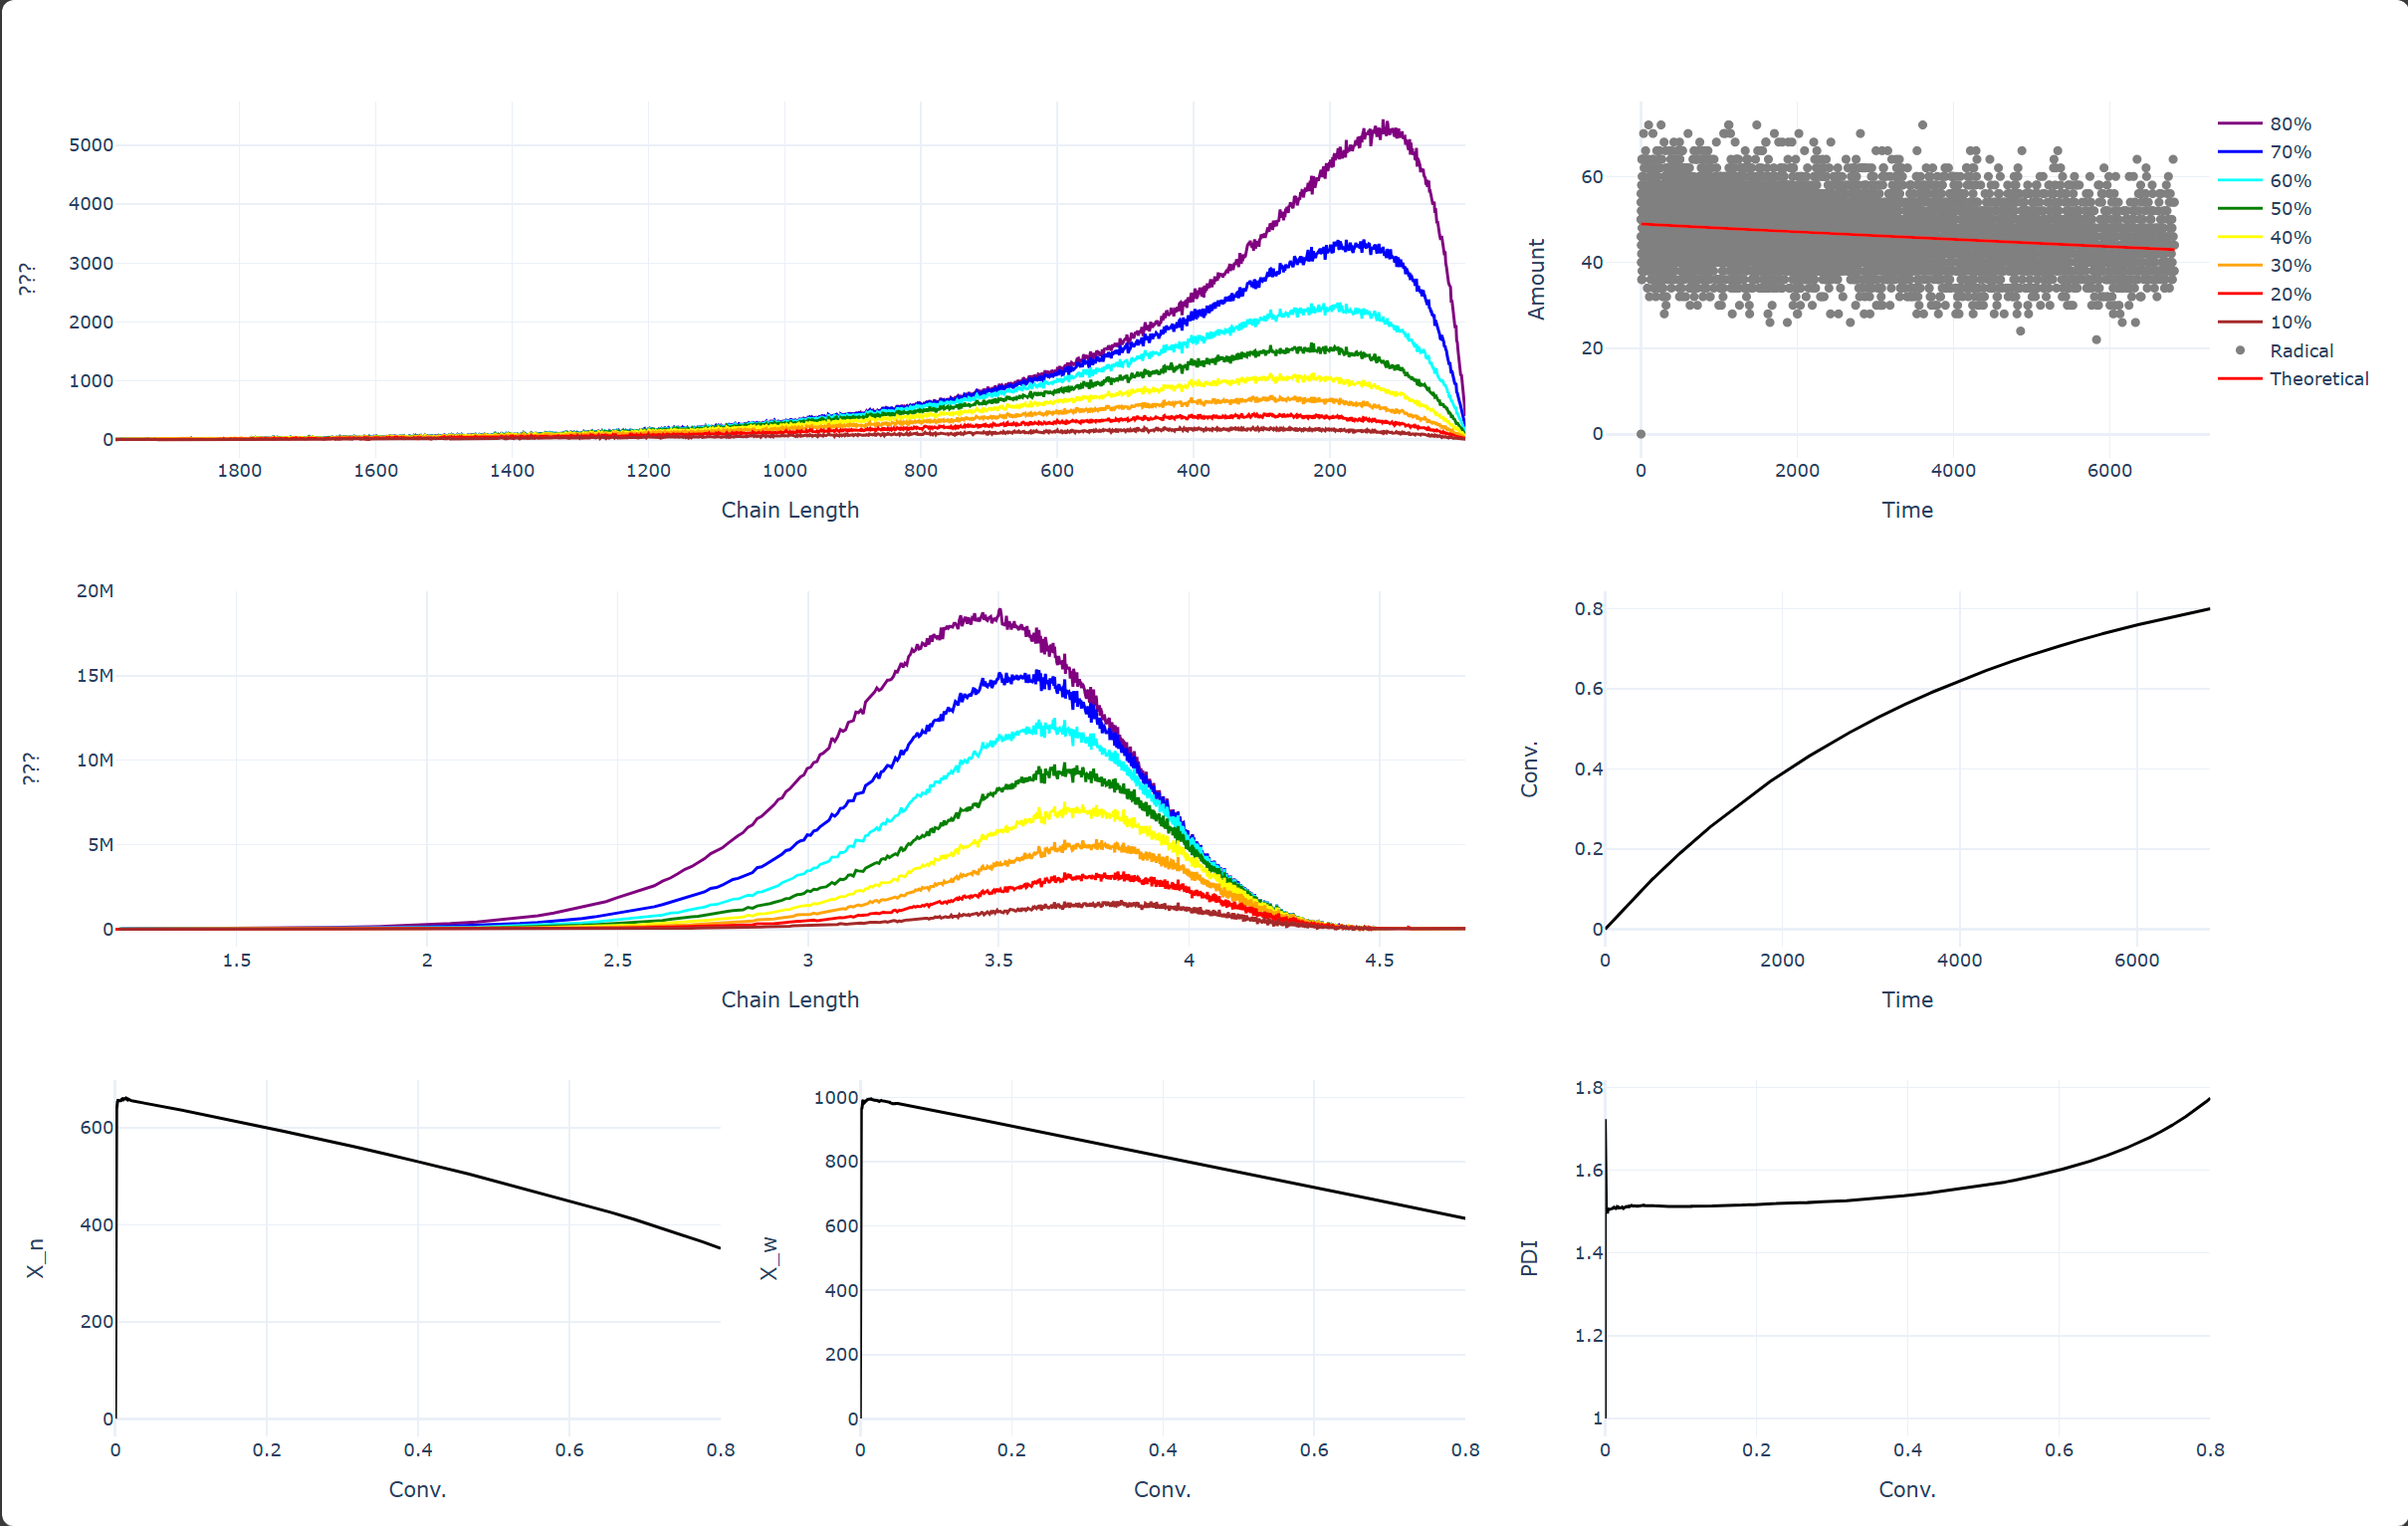</td>
    <td>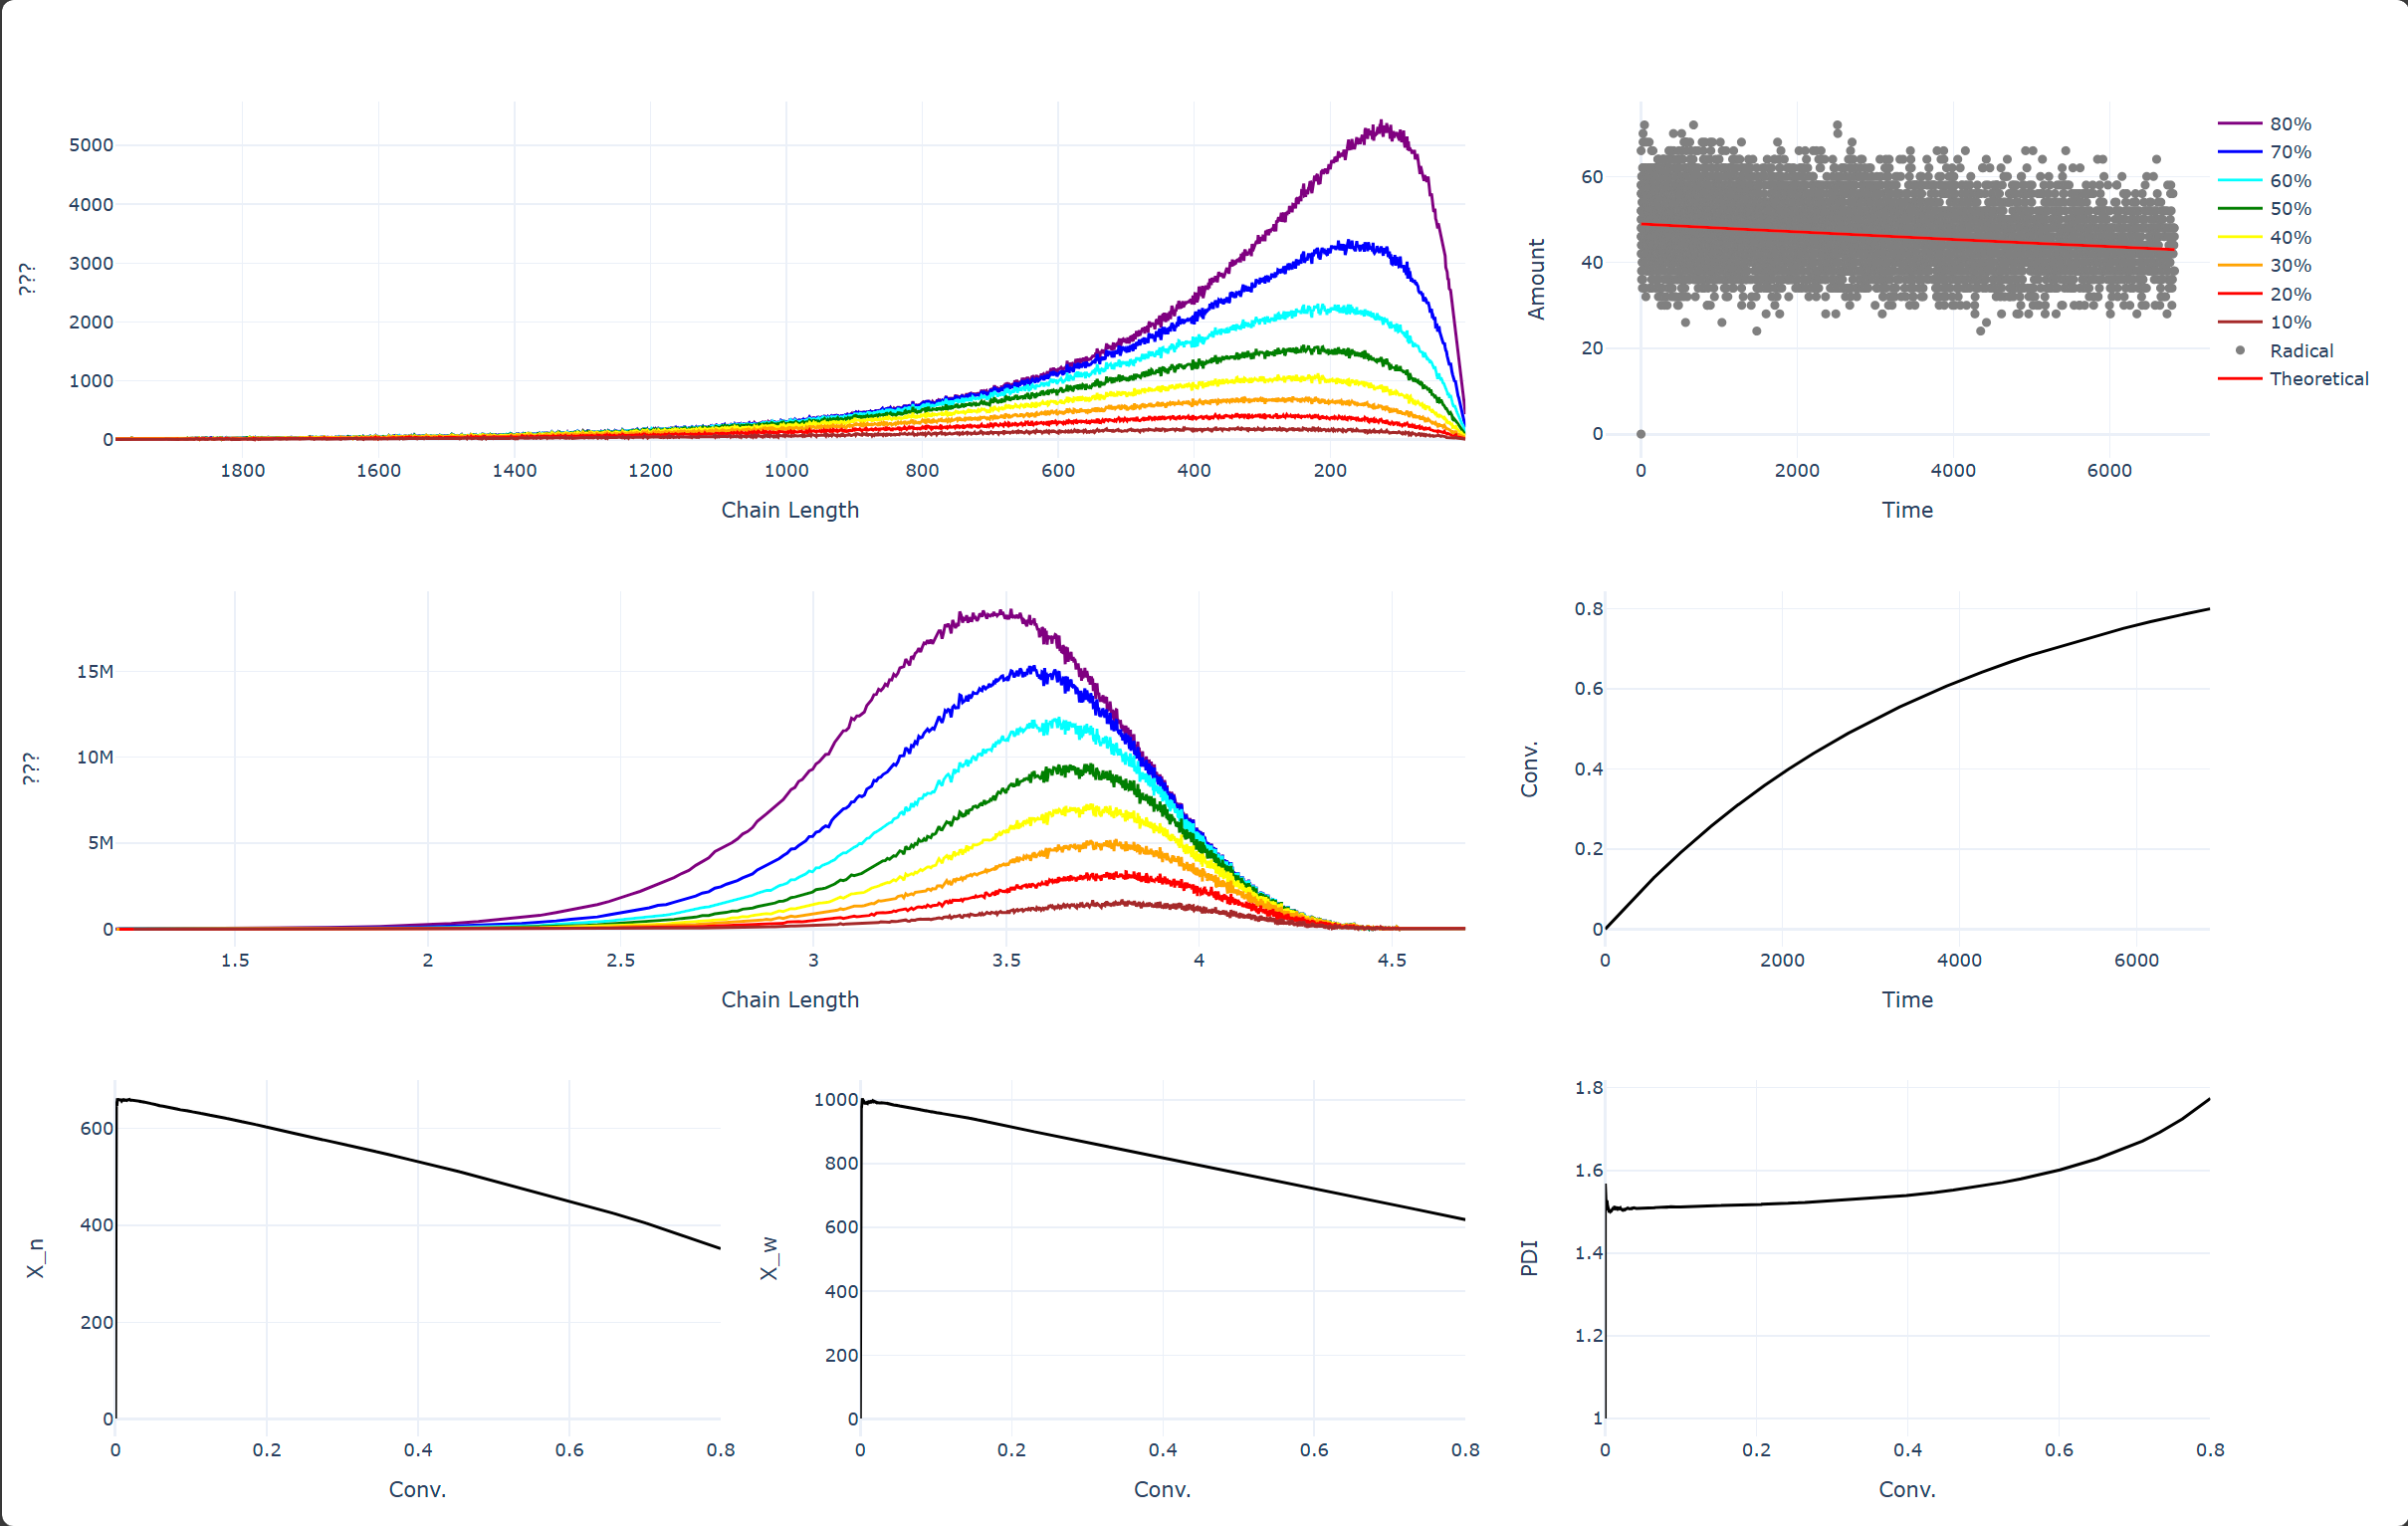</td>
    <td></td>
    <td></td>
  </tr>
    <tr>
    <td><b>Fig2-1: DT -- SSA</b></td>
    <td><b>Fig2-2: DT -- New (for loop)</b></td>
    <td><b>Fig2-3: DT -- New (Parallelogram)</b></td>
    <td><b>Fig2-4: DT -- New (Rectangle)</b></td>
  </tr>
  <tr>
    <td>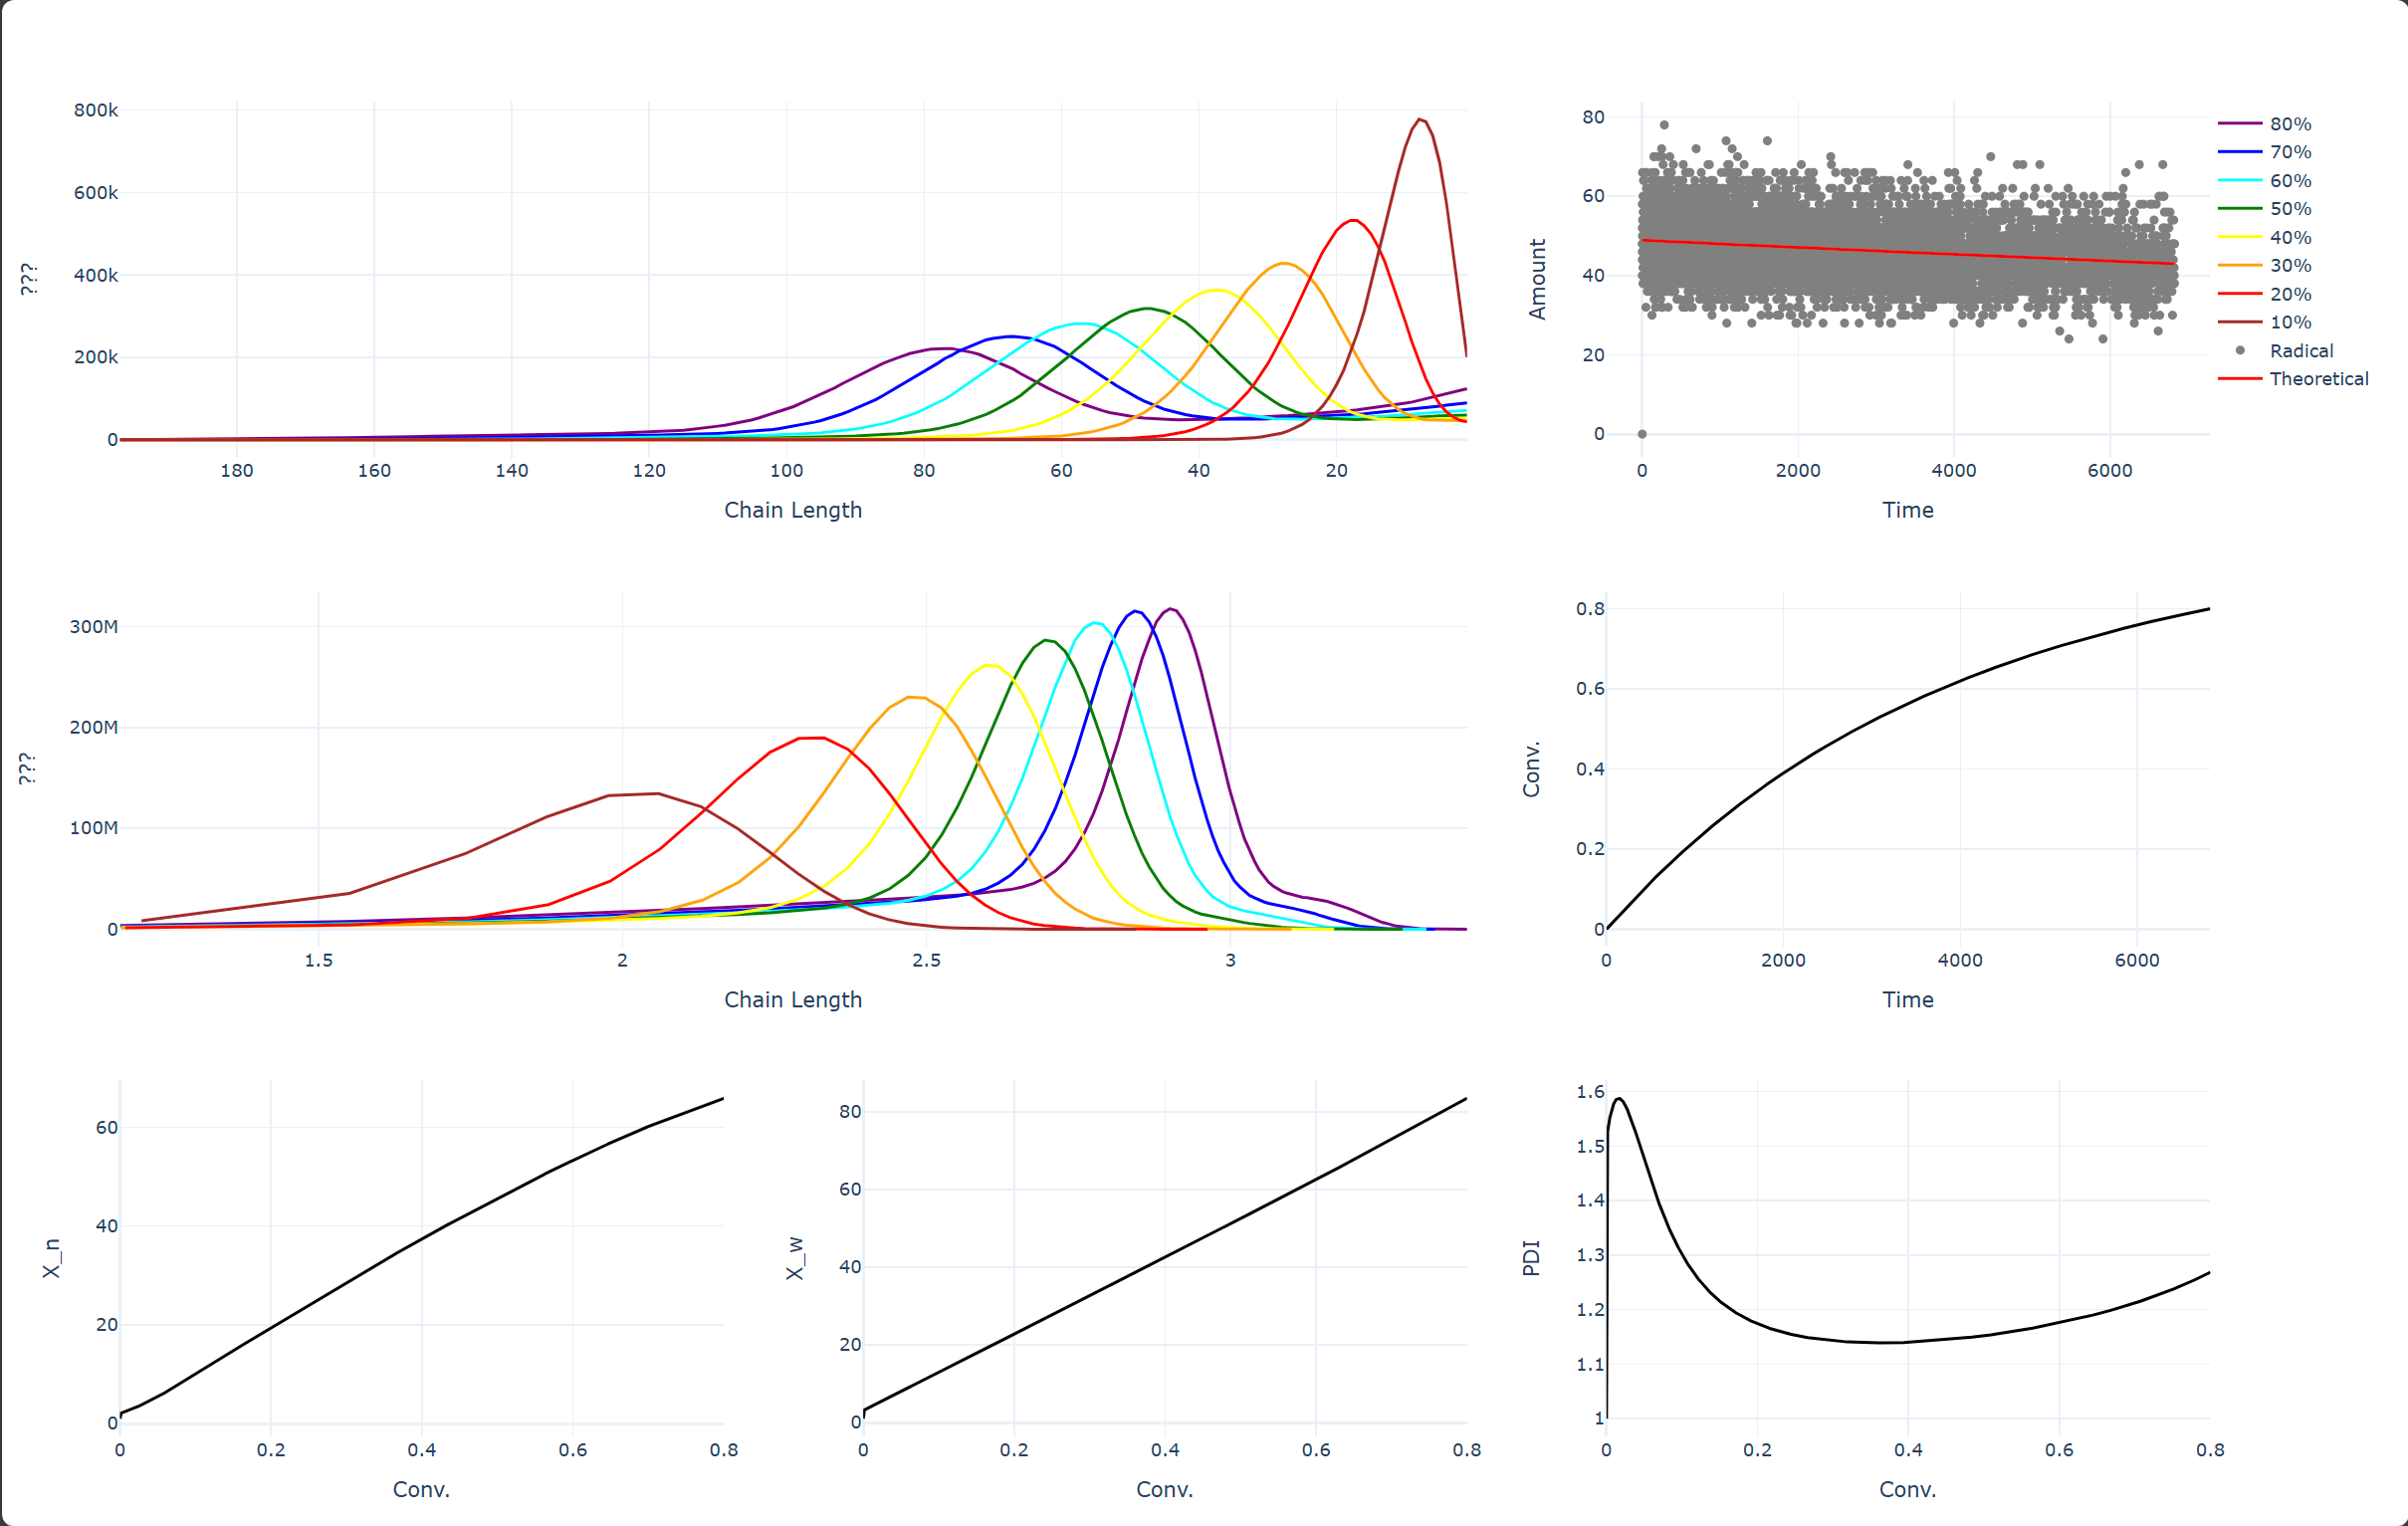</td>
    <td>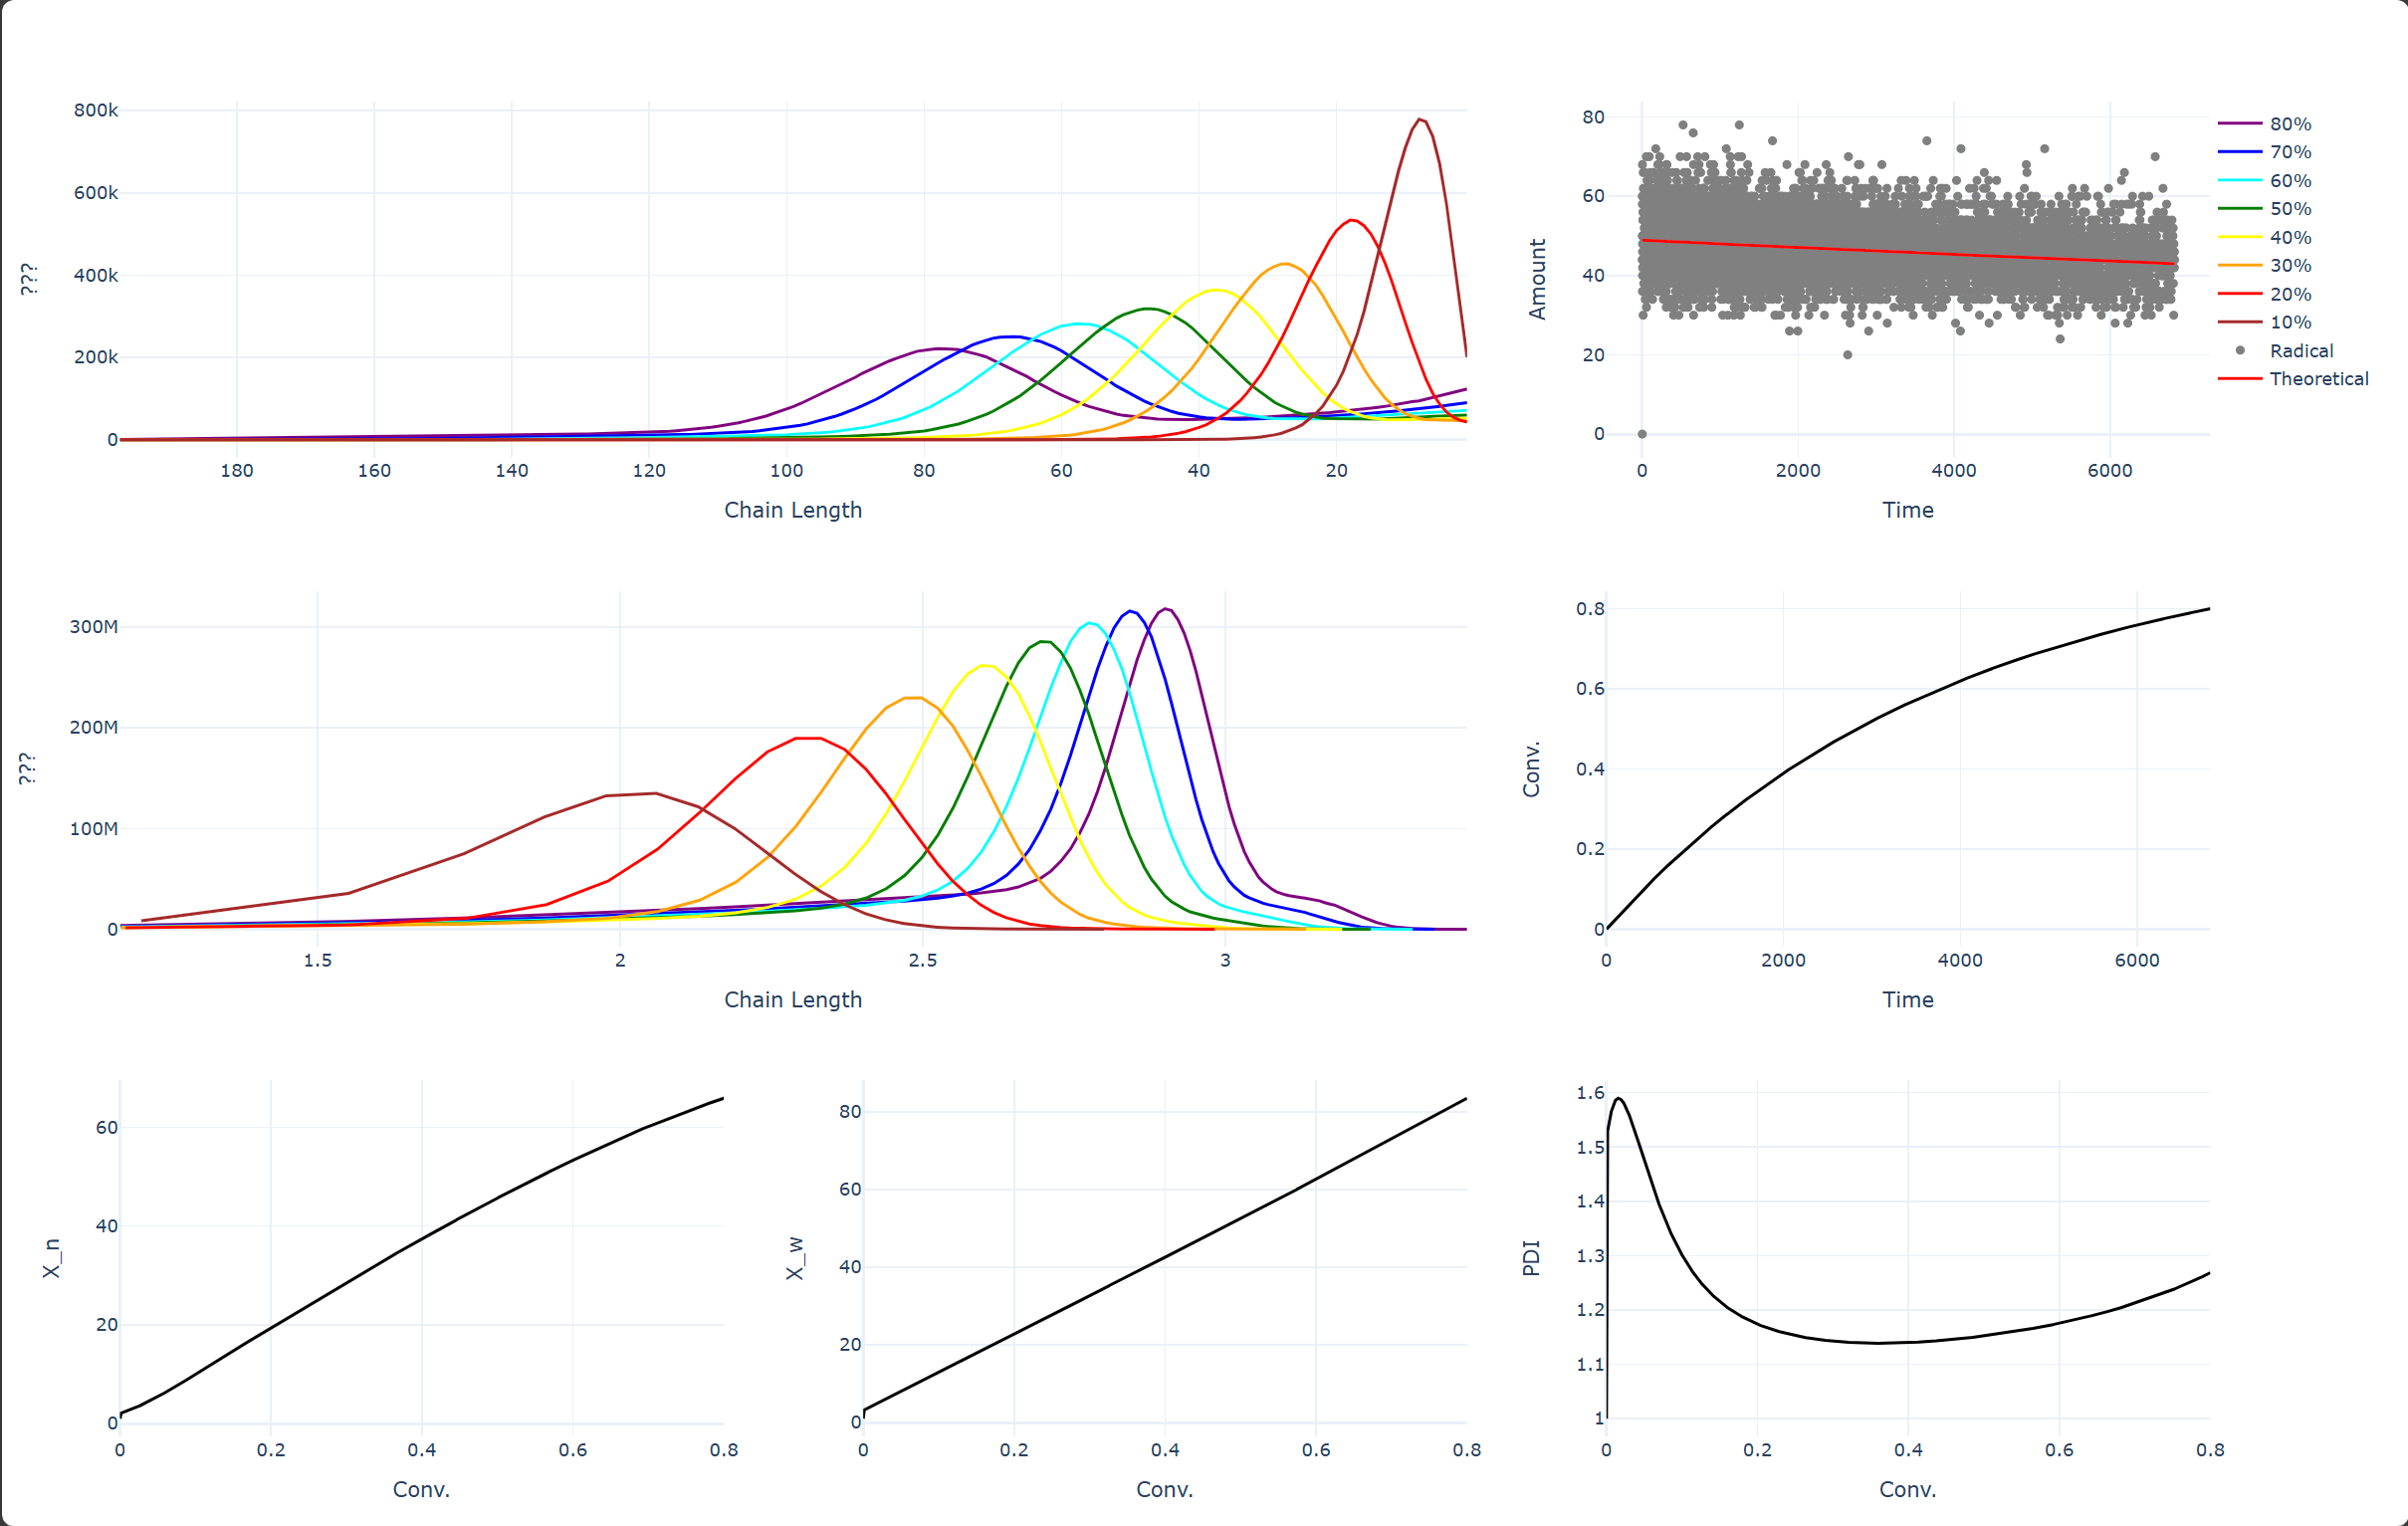</td>
    <td>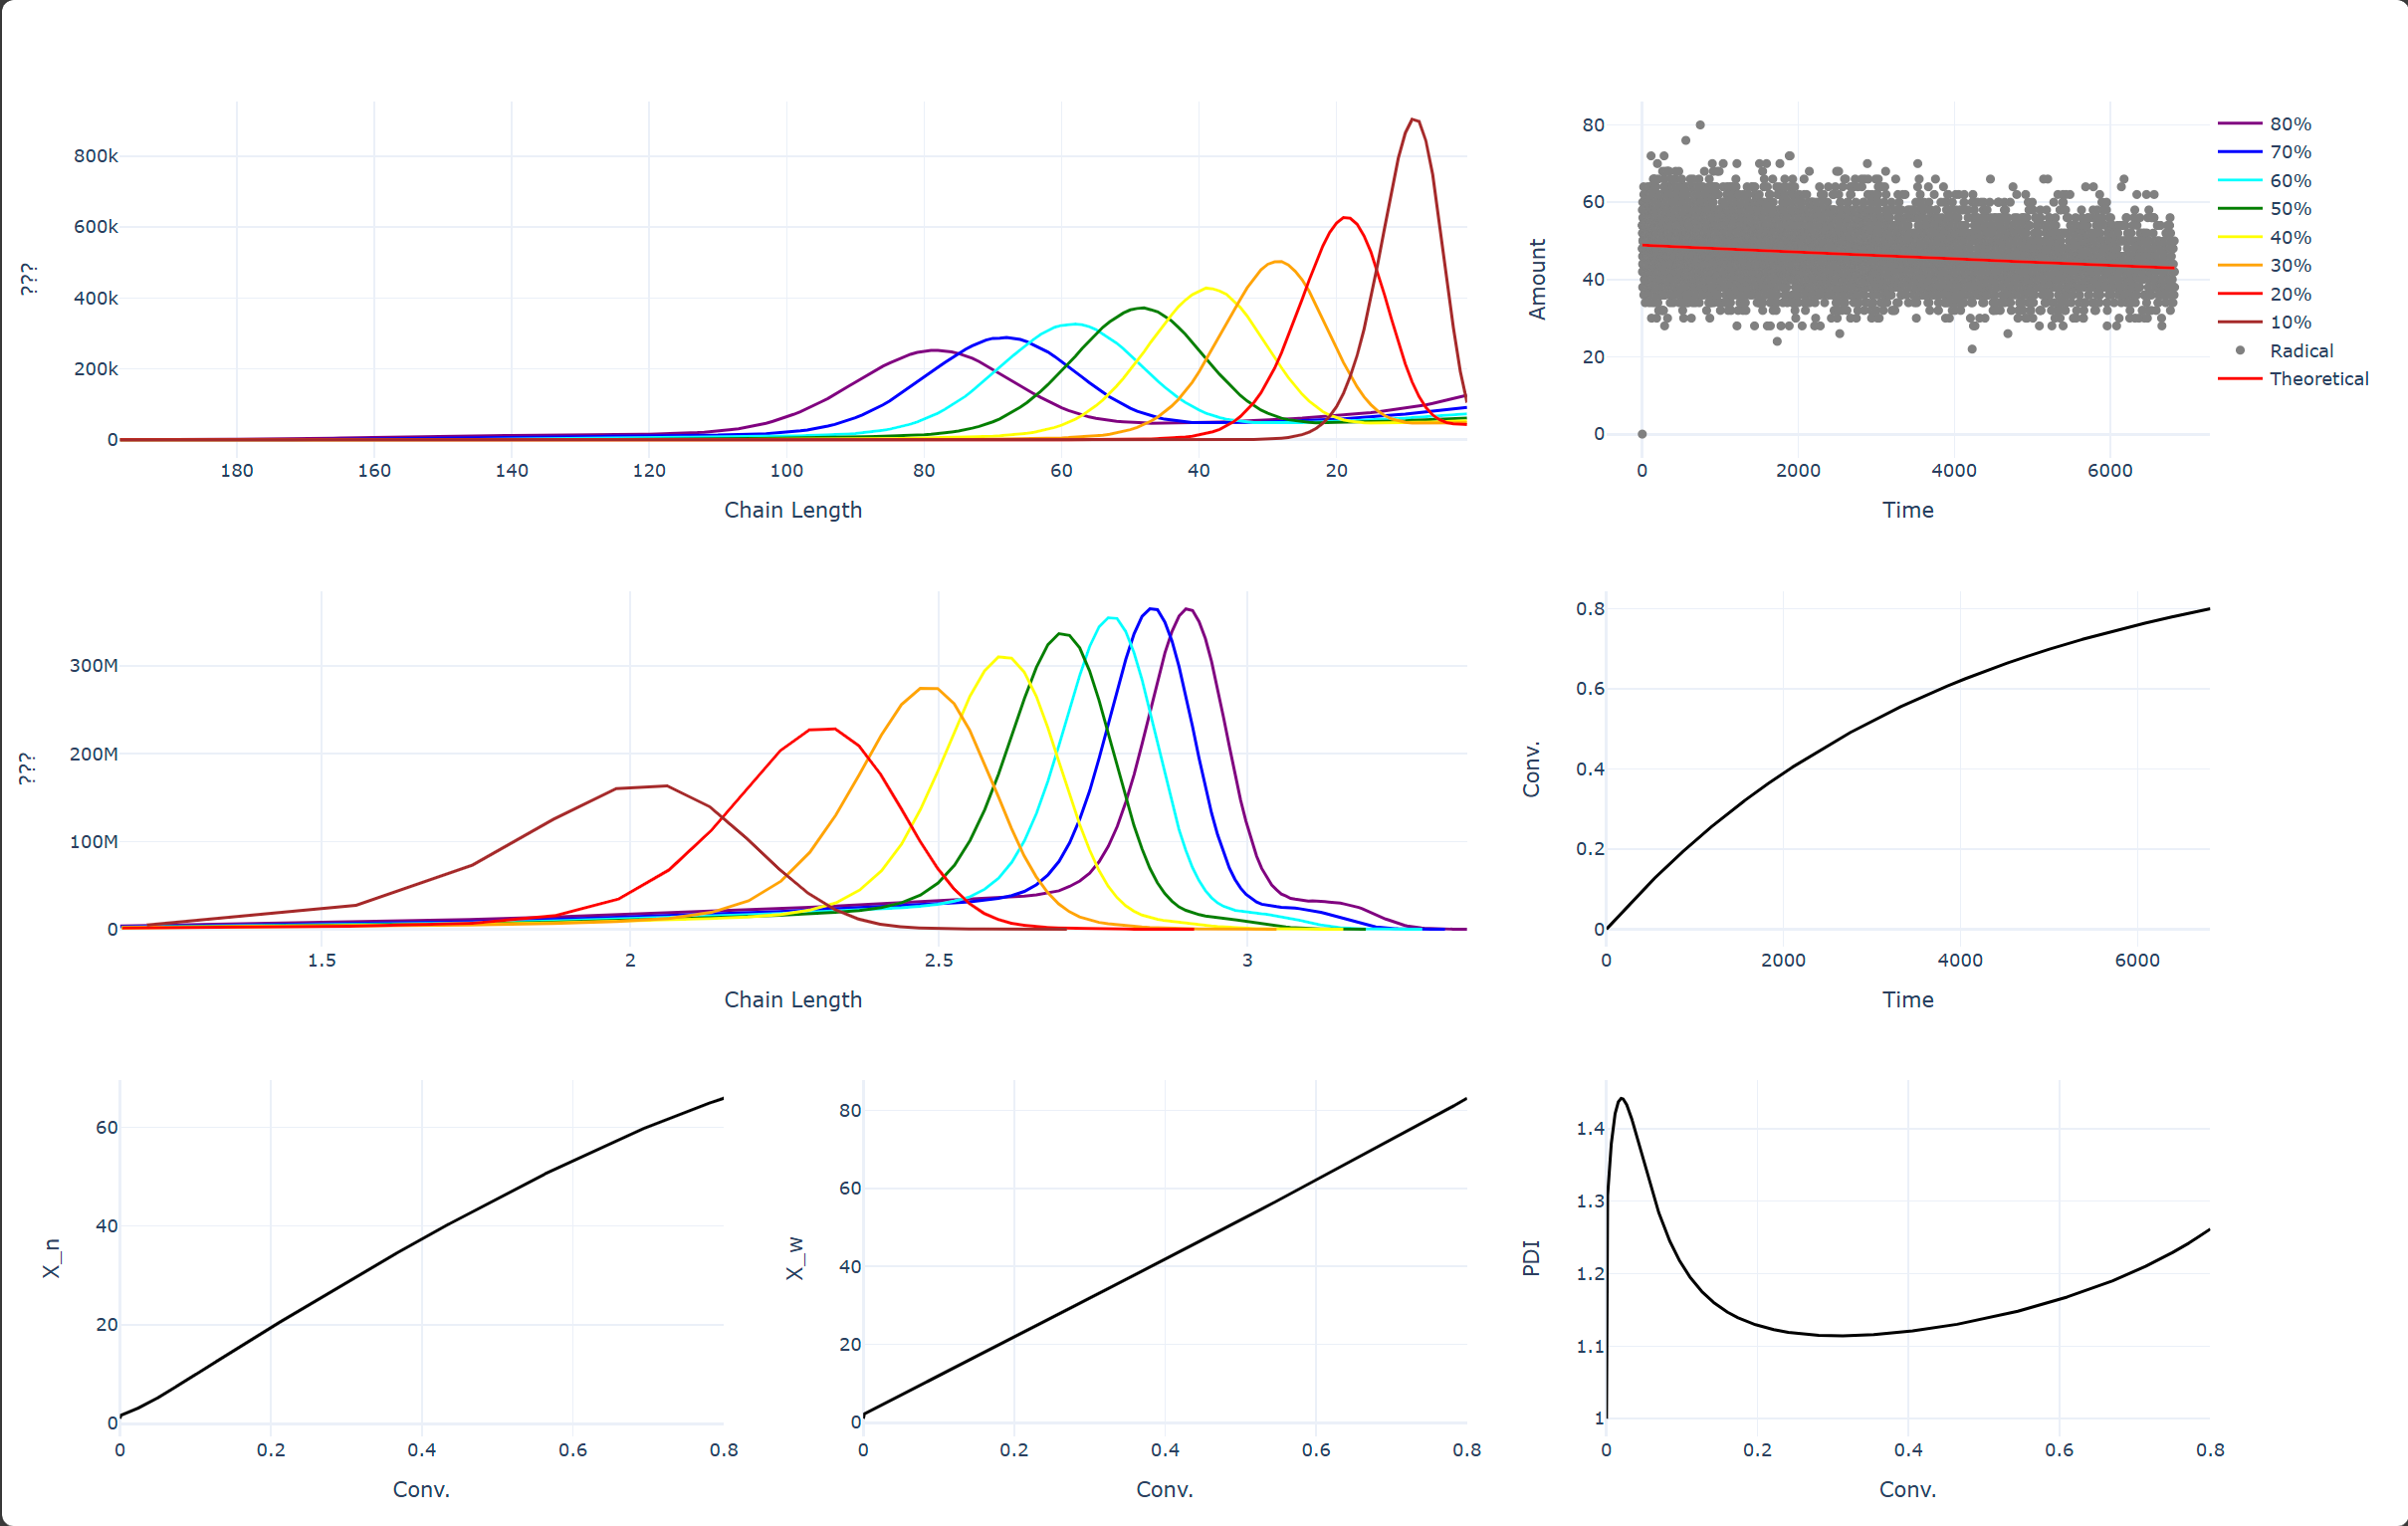</td>
    <td>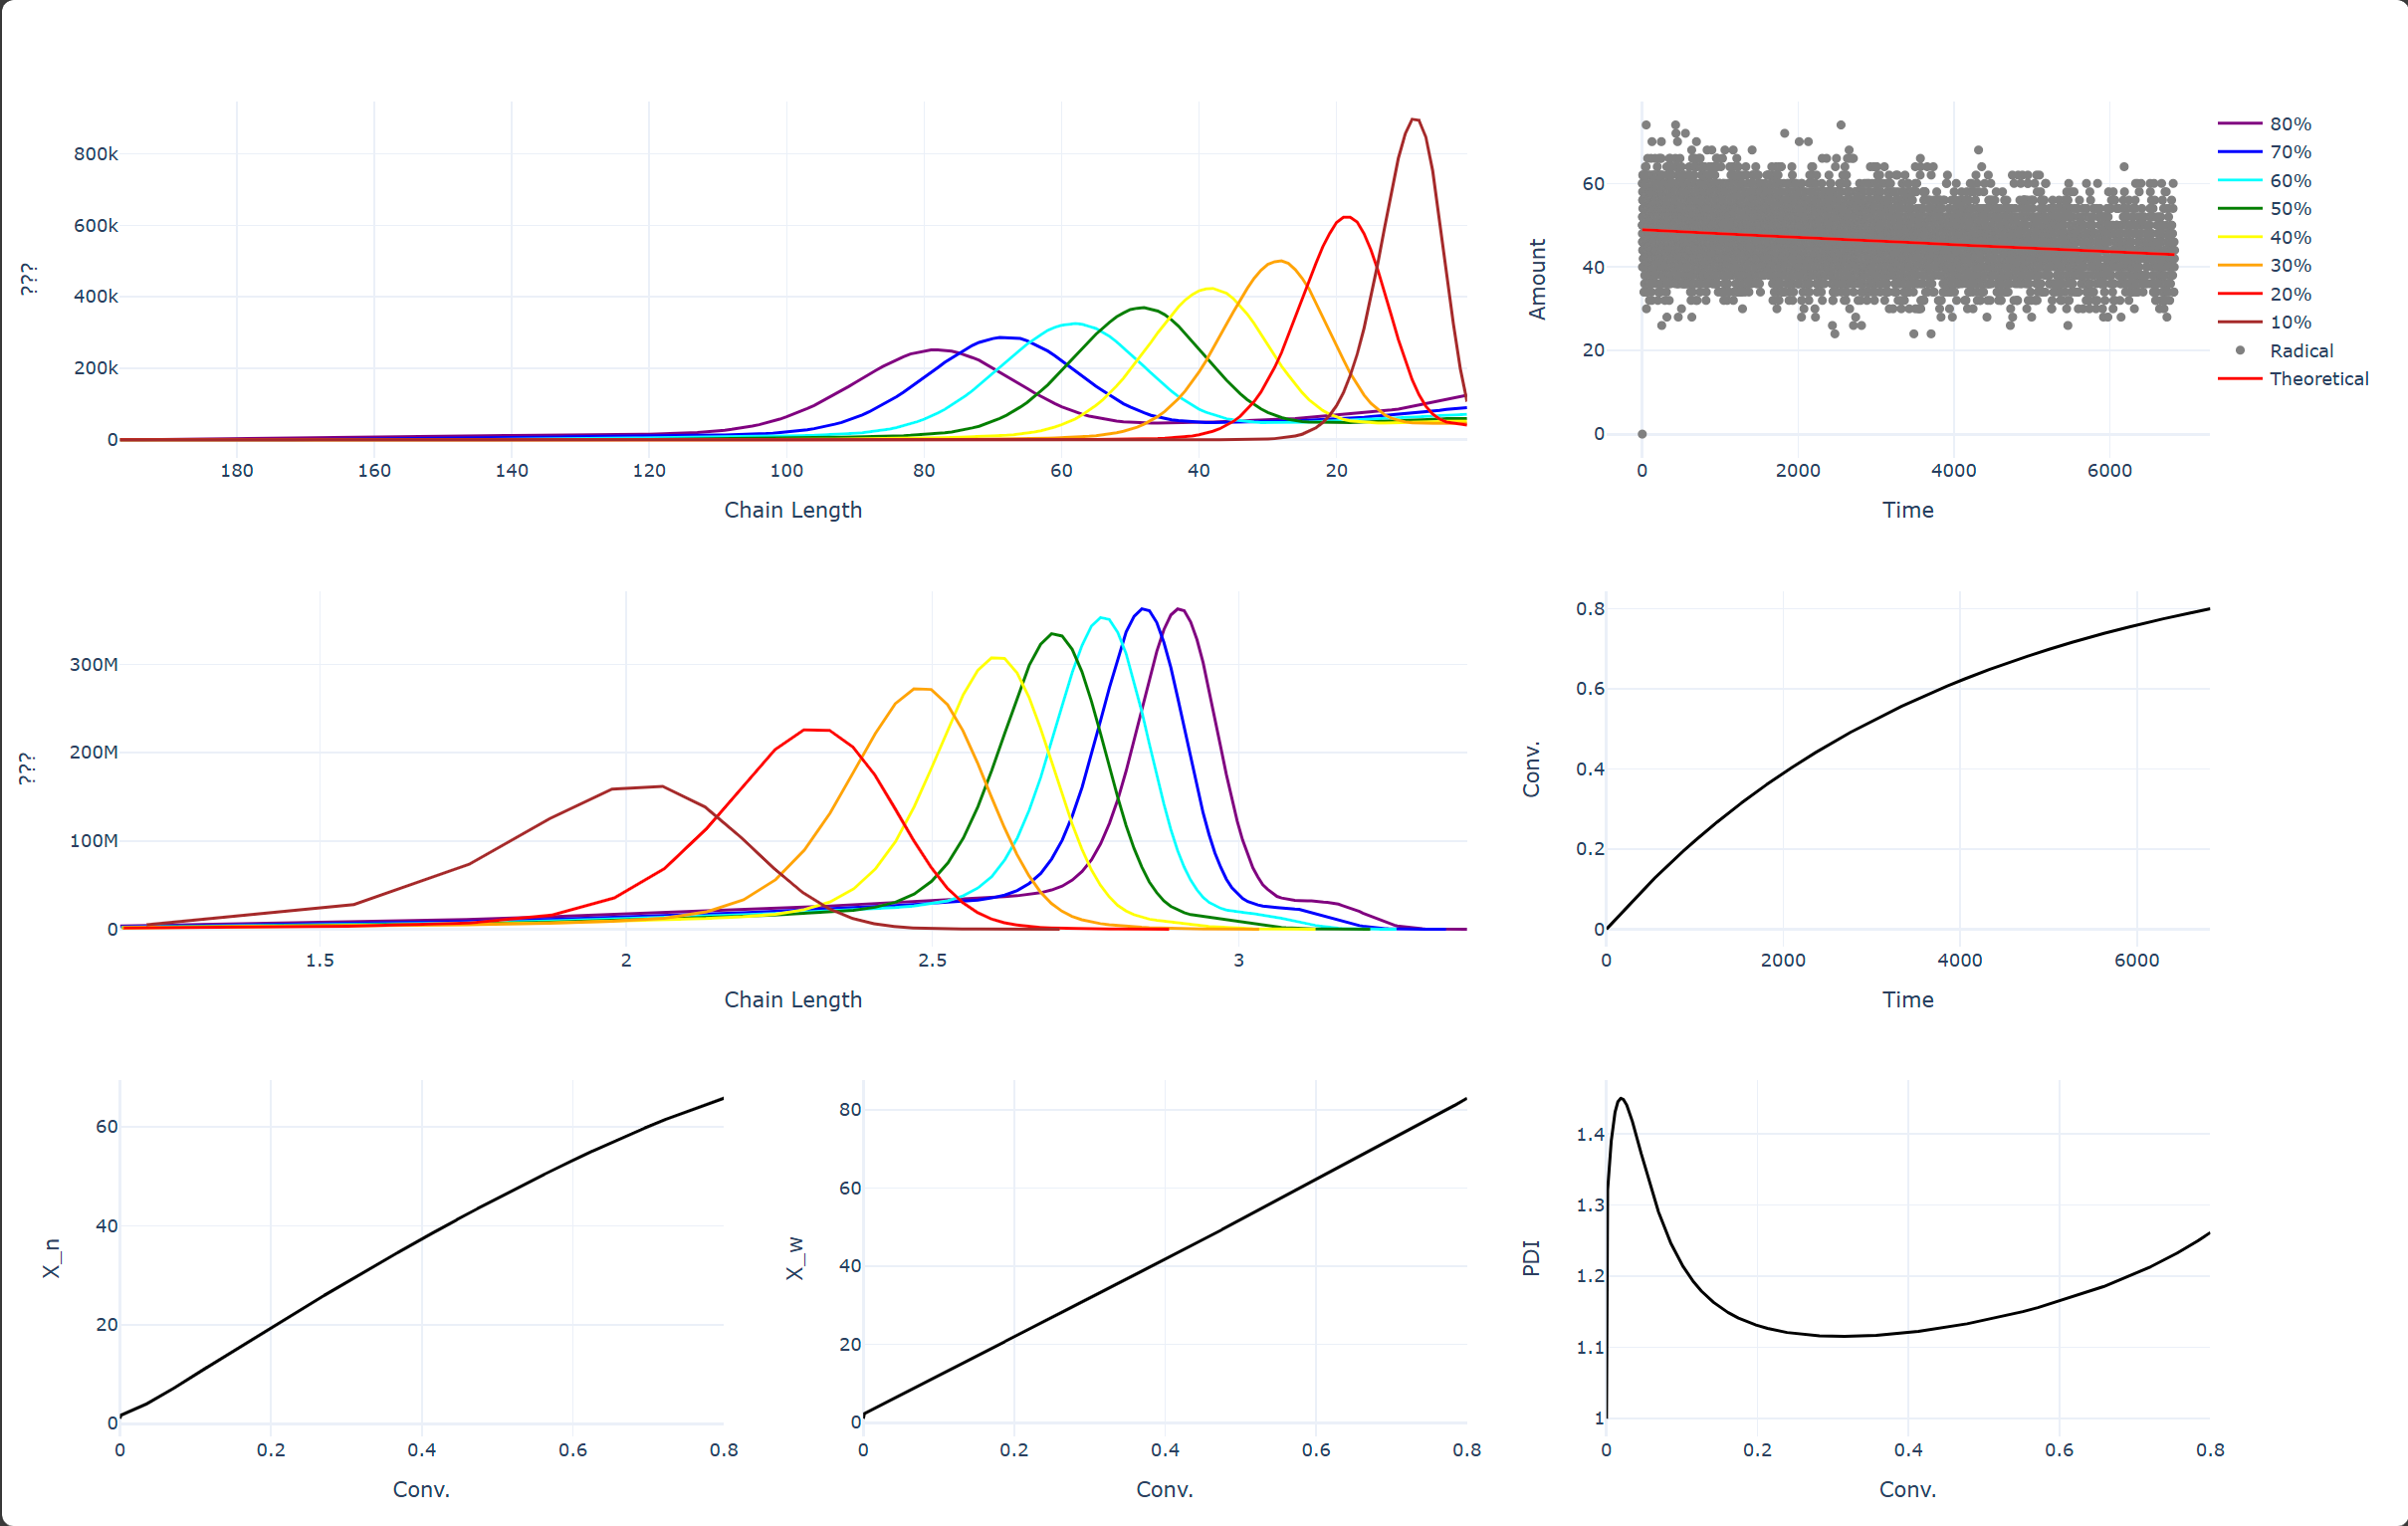</td>
  </tr>
</table>

## Hypothesis testing

using $\chi^2$ test

In [18]:
function find_cutoff(freq_vector, percentile=0.95)
    total = sum(freq_vector)
    cumsum_ratio = cumsum(freq_vector) ./ total
    findfirst(x -> x >= percentile, cumsum_ratio)
end

function Chi_Square_Test(x, y)
    Data_x = x[:Critical]["80%"][:Data]
    Data_y = y[:Critical]["80%"][:Data]
    cutoff_x = find_cutoff(Data_x, 0.95)
    cutoff_y = find_cutoff(Data_y, 0.95)
    cutoff = max(cutoff_x, cutoff_y)
    Data_x_trunc = Data_x[1:cutoff]
    Data_y_trunc = Data_y[1:cutoff]
    contingency_table = vcat(Data_x_trunc', Data_y_trunc')
    chi2_test = ChisqTest(contingency_table)

    p = Data_x_trunc ./ sum(Data_x_trunc)
    q = Data_y_trunc ./ sum(Data_y_trunc)
    m = 0.5 .* (p .+ q)
    kl_pm = sum(p .* log.(p ./ m)) / log(2)
    kl_qm = sum(q .* log.(q ./ m)) / log(2)
    js_divergence = 0.5 * (kl_pm + kl_qm)

    return (chi2_test=chi2_test, js_divergence=js_divergence)
end

Chi_Square_Test (generic function with 1 method)

In [19]:
Chi_Square_Test(Data_FRP_SSA, Data_FRP_New)

(chi2_test = Pearson's Chi-square Test
-------------------------
Population details:
    parameter of interest:   Multinomial Probabilities
    value under h_0:         [9.71178e-5, 9.69456e-5, 0.000125941, 0.000125717, 0.000142378, 0.000142125, 0.000178262, 0.000177946, 0.000205811, 0.000205446  …  8.56582e-5, 8.55063e-5, 8.9015e-5, 8.88572e-5, 8.40376e-5, 8.38886e-5, 8.16068e-5, 8.14621e-5, 8.70472e-5, 8.68929e-5]
    point estimate:          [9.36778e-5, 0.000100386, 0.000129299, 0.000122359, 0.000136238, 0.000148265, 0.000180417, 0.000175791, 0.00021118, 0.000200077  …  8.58135e-5, 8.53509e-5, 8.85892e-5, 8.92831e-5, 8.44257e-5, 8.35005e-5, 8.51196e-5, 7.79492e-5, 8.90518e-5, 8.48883e-5]
    95% confidence interval: [(7.604e-5, 0.0001154), (8.206e-5, 0.0001228), (0.0001083, 0.0001544), (0.0001019, 0.0001469), (0.0001146, 0.000162), (0.0001256, 0.000175), (0.0001552, 0.0002097), (0.0001509, 0.0002047), (0.0001838, 0.0002427), (0.0001734, 0.0002308)  …  (6.901e-5, 0.0001067), (6.86e-

$p$-value$>0.05$.

In [20]:
Chi_Square_Test(Data_DT_SSA, Data_DT_New) # for loop

(chi2_test = Pearson's Chi-square Test
-------------------------
Population details:
    parameter of interest:   Multinomial Probabilities
    value under h_0:         [0.00534654, 0.00534756, 0.00516215, 0.00516314, 0.00496419, 0.00496514, 0.00476396, 0.00476486, 0.00458691, 0.00458779  …  0.00112035, 0.00112056, 0.00105543, 0.00105563, 0.000989028, 0.000989216, 0.000941676, 0.000941855, 0.000886117, 0.000886286]
    point estimate:          [0.00535692, 0.00533717, 0.0051759, 0.00514939, 0.00495849, 0.00497084, 0.00475915, 0.00476967, 0.0045841, 0.0045906  …  0.00111357, 0.00112734, 0.00106433, 0.00104674, 0.000985419, 0.000992825, 0.000943108, 0.000940423, 0.000897332, 0.000875072]
    95% confidence interval: [(0.005301, 0.005413), (0.005281, 0.005394), (0.005121, 0.005231), (0.005095, 0.005205), (0.004905, 0.005013), (0.004917, 0.005025), (0.004706, 0.004812), (0.004717, 0.004823), (0.004532, 0.004636), (0.004539, 0.004643)  …  (0.001088, 0.00114), (0.001102, 0.001153), (0.001039

$p$-value$>0.05$.

In [21]:
Chi_Square_Test(Data_DT_SSA, Data_DT_New1)

(chi2_test = Pearson's Chi-square Test
-------------------------
Population details:
    parameter of interest:   Multinomial Probabilities
    value under h_0:         [0.00538526, 0.00539641, 0.00518535, 0.00519609, 0.0049821, 0.00499242, 0.00477222, 0.0047821, 0.00457543, 0.0045849  …  0.000990045, 0.000992095, 0.000938784, 0.000940728, 0.000885296, 0.00088713, 0.000843047, 0.000844793, 0.000811905, 0.000813587]
    point estimate:          [0.00535189, 0.00542977, 0.00517104, 0.00521041, 0.00495384, 0.00502068, 0.00475468, 0.00479963, 0.0045798, 0.00458053  …  0.00111252, 0.00086962, 0.00106333, 0.000816186, 0.000984494, 0.000787932, 0.000942222, 0.000745617, 0.000896489, 0.000729003]
    95% confidence interval: [(0.005296, 0.005408), (0.005373, 0.005487), (0.005116, 0.005227), (0.005155, 0.005266), (0.0049, 0.005008), (0.004967, 0.005075), (0.004702, 0.004808), (0.004747, 0.004853), (0.004528, 0.004632), (0.004529, 0.004633)  …  (0.001087, 0.001138), (0.0008472, 0.0008926), (0.00

$p$-value$<0.05$, but Jensen-Shannon (JS) Divergence very small (close to 0), Can be considered as approximate.

In [22]:
Chi_Square_Test(Data_DT_SSA, Data_DT_New2)

(chi2_test = Pearson's Chi-square Test
-------------------------
Population details:
    parameter of interest:   Multinomial Probabilities
    value under h_0:         [0.00533585, 0.00535194, 0.00517048, 0.00518608, 0.00496606, 0.00498104, 0.00475201, 0.00476635, 0.00458499, 0.00459882  …  0.000984123, 0.000987092, 0.00093997, 0.000942806, 0.000883252, 0.000885916, 0.000848404, 0.000850963, 0.000809519, 0.000811961]
    point estimate:          [0.00534936, 0.00533842, 0.00516859, 0.00518797, 0.0049515, 0.00499561, 0.00475243, 0.00476593, 0.00457763, 0.00460618  …  0.00111199, 0.00085922, 0.00106282, 0.000819952, 0.000984029, 0.000785139, 0.000941777, 0.000757591, 0.000896066, 0.000725415]
    95% confidence interval: [(0.005293, 0.005406), (0.005283, 0.005395), (0.005114, 0.005224), (0.005133, 0.005244), (0.004898, 0.005006), (0.004942, 0.00505), (0.0047, 0.004806), (0.004713, 0.004819), (0.004526, 0.00463), (0.004554, 0.004659)  …  (0.001087, 0.001138), (0.000837, 0.0008821), (0.00

$p$-value$<0.05$, but JS Divergence very small, approximate.